In [189]:
#select geno
import h5py
from Bio import AlignIO
import pickle
from matplotlib import pyplot as plt
import numpy as np
#run annot
from scipy.sparse import lil_matrix
import random


In [190]:
#save each cl
import colour
import numpy as np

red = colour.Color('red')
blue = colour.Color('blue')
crange = [ c.get_hex_l() for c in red.range_to(blue, 100) ]
print(crange)

with open( 'crange.pkl' , 'wb') as crangeout:
    crangeout.write(pickle.dumps(crange))

['#ff0000', '#ff0a00', '#ff1500', '#ff1f00', '#ff2900', '#ff3400', '#ff3e00', '#ff4800', '#ff5200', '#ff5d00', '#ff6700', '#ff7100', '#ff7c00', '#ff8600', '#ff9000', '#ff9b00', '#ffa500', '#ffaf00', '#ffb900', '#ffc400', '#ffce00', '#ffd800', '#ffe300', '#ffed00', '#fff700', '#fcff00', '#f2ff00', '#e8ff00', '#deff00', '#d3ff00', '#c9ff00', '#bfff00', '#b4ff00', '#aaff00', '#a0ff00', '#95ff00', '#8bff00', '#81ff00', '#76ff00', '#6cff00', '#62ff00', '#58ff00', '#4dff00', '#43ff00', '#39ff00', '#2eff00', '#24ff00', '#1aff00', '#0fff00', '#05ff00', '#00ff05', '#00ff0f', '#00ff1a', '#00ff24', '#00ff2e', '#00ff39', '#00ff43', '#00ff4d', '#00ff58', '#00ff62', '#00ff6c', '#00ff76', '#00ff81', '#00ff8b', '#00ff95', '#00ffa0', '#00ffaa', '#00ffb4', '#00ffbf', '#00ffc9', '#00ffd3', '#00ffde', '#00ffe8', '#00fff2', '#00fffc', '#00f7ff', '#00edff', '#00e3ff', '#00d8ff', '#00ceff', '#00c4ff', '#00b9ff', '#00afff', '#00a5ff', '#009bff', '#0090ff', '#0086ff', '#007cff', '#0071ff', '#0067ff', '#005dff'

In [191]:
treefile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln.treefile'
alnfile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln'
alnh5 = alnfile+'.h5'

In [192]:
#choose sequence
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array'][:]
print(align_array.shape)
msa = AlignIO.read(alnfile , format = 'fasta')

def clipID(ID):
    return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
IDs = {i:rec.id for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )
print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )

(35244, 29903)
[('hCoV-19/Wuhan-Hu-1/2019|EPI_ISL_402125', 0), ('hCoV-19/Iceland/447/2020|EPI_ISL_424471|2020-03-20', 1), ('hCoV-19/Scotland/EDB410/2020|EPI_ISL_426002|2020-03-30', 2), ('hCoV-19/Scotland/EDB413/2020|EPI_ISL_426004|2020-03-29', 3), ('hCoV-19/Scotland/EDB421/2020|EPI_ISL_426006|2020-03-30', 4), ('hCoV-19/Wuhan/Hu-1/2019|EPI_ISL_402125|2019-12-31', 5), ('hCoV-19/Sichuan/SC-NJ-089/2020|EPI_ISL_451338|2020-02-05', 6), ('hCoV-19/Sichuan/SC-WCH3-259/2020|EPI_ISL_451385|2020-02-03', 7), ('hCoV-19/Sichuan/SC-WCH4-285/2020|EPI_ISL_451387|2020-01-27', 8), ('hCoV-19/Sichuan/SC-WCH4-286/2020|EPI_ISL_451388|2020-02-10', 9)]


In [193]:
seq = 'hCoV-19/Iceland/447/2020|EPI_ISL_424471|2020-03-20'
print('seq chosen: ' , seq)
#index all non gap cols
aln_row = align_array[IDindex[seq],:]
nongap_cols = [ i for i,c in enumerate(list(aln_row)) if c != b'-' ]


seq chosen:  hCoV-19/Iceland/447/2020|EPI_ISL_424471|2020-03-20


In [ ]:
with open( alnfile+ 'blurmatr3.pkl' , 'rb') as matin:
    coevmat = pickle.loads(matin.read())


In [ ]:
submat_coev = coevmat[: , nongap_cols ]
submat_aln = align_array[:,nongap_cols ]
plt.figure( figsize=(30,200))
plt.spy(submat_coev ,  markersize = 1)

In [ ]:
qseq = b''.join(aln_row[nongap_cols])
qfile = 'covid_geno.fasta'
with open(qfile , 'w') as geno_out:
    geno_out.write((b'>testgeno\n'+qseq).decode())
    #print( (b'>testgeno\n'+qseq).decode())


In [ ]:
import subprocess
import shlex
import pandas as pd 
#collapse codons
#use tblastn to map to prot

def runblastx( qseq , outannot = 'outannot.txt' , outfmt = None ):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = 'blastx -query '+ qfile + ' -db covid_prots -outfmt' + outfmt + ' -out ' + outannot  
    p = subprocess.run( shlex.split(args) )
    return p , outannot
out = 'outannot.txt'
p,annot = runblastx(qfile  )

annotation = pd.read_csv( out , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]
print(annotation)
print(len(annotation), ' orfs detected')

#recluster codons
#load blast results into df

In [ ]:
#select longest nice hit
from Bio import Seq
rows = []
for ID in annotation.sseqid.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.sseqid == ID ]
    rows.append(sub.index[0] ) 
annotation = annotation.loc[rows]
print(len(annotation))
rows = []

for ID in annotation.qstart.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.qstart == ID ]
    rows.append(sub.index[0] )
annotation = annotation.loc[rows]
print(len(annotation))

genes =  {}
prots = {}

for i,r in annotation.iterrows():
    genes[i] = qseq[r.qstart-1:r.qend-1].decode()
    #print(genes[i])
    prots[i] = str(Seq.Seq( genes[i]).translate( ) )
annotation = annotation.sort_values( ['qstart'] )
annotation['prots'] = annotation.index.map(prots)
annotation['genes'] = annotation.index.map(genes)
annotation = annotation[annotation.slen < 2000]
aln_regions = np.array(list(zip(list(annotation.qstart),list(annotation.qend))))
aln_regions= aln_regions[1:,:]
aln_len = np.array(list( annotation.qend - annotation.qstart))

annotation = pd.DataFrame.sort_values(annotation, by='qstart')
print(annotation)

In [ ]:
annotation.to_csv('./gisaid/'+seq.replace('/', '_').replace('|','_')+'.csv')

In [ ]:
print('summing up events on codons')
codonmat = np.zeros( (submat_coev.shape[0] , int(submat_coev.shape[1]/3) +1  ))
count = 0
print(codonmat.shape)
print(submat_coev.shape)
try:
    submat_coev = submat_coev.todense()
except AttributeError:
    print( 'already dense')
codon_dict = {}
for i,r in annotation.iterrows():
    for j,codon in enumerate(range(r.qstart-1, r.qend-1 , 3 )):
        codon_dict[codon] = count
        cols = np.sum( submat_coev[:, codon:codon+2] , axis = 1 )
        codonmat[:,count] = cols.ravel()
        count+=1
        if count%500 == 0:
            print(count/lenprots)

codonthresh = codonmat[codonmat>0] = 1

In [ ]:
codon_dict_rev = dict(zip ( codon_dict.values() , codon_dict.keys( ) ) )

In [ ]:
plt.figure( figsize=(30,50) )
plt.spy(codonmat , markersize = 1)

In [ ]:
import pickle
with open( alnfile+'blurmat_codonsr3.pkl' , 'wb') as blurout:
    blurout.write(pickle.dumps(lil_matrix(codonmat) ))



In [ ]:
import pickle

with open( alnfile+'blurmat_codons.pklr3' , 'rb') as blurout:
    codonmat = pickle.loads(blurout.read())
sparsedf = pd.DataFrame.sparse.from_spmatrix(codonmat)
nzx,nzy = codonmat.nonzero()
print(nzx.shape)
print(nzy.shape)

In [ ]:
datablock = np.vstack([nzx,nzy]).T
print(datablock.shape)

In [ ]:
#save each cl
import colour
import numpy as np

red = colour.Color('red')
blue = colour.Color('blue')
crange = [ c.get_hex_l() for c in red.range_to(blue, np.amax(cluster_labelsb)) ]
print(crange)

with open( 'crange.pkl' , 'wb') as crangeout:
    crangeout.write(pickle.dumps(crange))

In [ ]:
#use plotly. linearized cluster map. highlight on structs. tree viewer for events

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[],
    y=[0.75, 0.75],
    text=["Unfilled Rectangle", "Filled Rectangle"],
    mode="text",
))
# Set axes properties
fig.update_xaxes(range=[0, 7], showgrid=False)
fig.update_yaxes(range=[0, 3.5])
fig.add_shape(
        # filled Rectangle
            type="rect",
            x0=3,
            y0=10,
            x1=6,
            y1=20,
            line=dict(
                color="RoyalBlue",
                width=2,
            ),
            fillcolor="LightSkyBlue",
        )

fig.update_shapes(dict(xref='x', yref='y'))
fig.show()





In [ ]:
import plotly.express as px

nzdf = pd.DataFrame( data = codonmat , columns = ['nzx', 'nzy'] , index = np.arange(nzx.shape[0]) )
nzdf['clusters'] = 0
nzdf['colors'] = '0'
nzdf['size'] = .1

#todo, label the change on each event
for i,l in enumerate(np.unique(cluster_labelsb)):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        labels =  np.where(cluster_labelsb==l)
        nzdf['clusters'][ nzdf['nzy'].isin( labels ) ] =  l
        nzdf['colors'][ nzdf['nzy'].isin(labels) ] =  crange[l]
        nzdf['size'][ nzdf['nzy'].isin(labels) ] =  1

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=700, algorithm='randomized', n_iter=20, random_state=0 , tol=0.0)
codon_reduce = svd.fit_transform( codonmat.T )

In [ ]:
from sklearn.cluster import MiniBatchKMeans , DBSCAN

apb = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=100, batch_size=200, verbose=1, compute_labels=True , random_state= 0   )
#apb = DBSCAN( eps = .2 , metric='jaccard', metric_params=None, algorithm='auto', leaf_size=25, p=None, n_jobs=-1)
cluster_labels_codon = apb.fit_predict(codonmat.T )
cluster_labels_raw = apb.fit_predict(submat_coev.T )
cluster_labels_reduced = apb.fit_predict(codon_reduce )


In [ ]:
#blurmat = blurmat.todense()
import copy
plt.figure( figsize=(30,200))
for cluster_labels in [ cluster_labels_codon , cluster_labels_reduced ]:
    l,c = np.unique(cluster_labels, return_counts= True)
    print(len(l))
    print(c)
    print(np.sum(c))
    for i,label in enumerate(np.unique(cluster_labels)):
        if len(cluster_labels[ cluster_labels==label ] ) < 200 and len(cluster_labels[ cluster_labels==label ] ) > 6:
            print('cluster:',label)
            print( 'cluster size:' ,len(cluster_labels[ cluster_labels==label ] ) )
            mask =  copy.deepcopy(codonmat)
            mask[:,  cluster_labelsb_raw!=label ] = 0
            plt.spy( mask, markersize = 1 , mfc = crange[i]  , mec = crange[i] )
    plt.show()

In [ ]:
l,c = np.unique(cluster_labels_raw, return_counts= True)
print(len(l))
print(c)
print(np.sum(c))
for i,label in enumerate(np.unique(cluster_labels_raw)):
    if len(cluster_labels[ cluster_labels==label ] ) < 200 and len(cluster_labels[ cluster_labels==label ] ) > 6:
        print('cluster:',label)
        print( 'cluster size:' ,len(cluster_labels[ cluster_labels==label ] ) )
        mask =  copy.deepcopy(submat_coev)
        mask[:,  cluster_labelsb_raw!=label ] = 0
        plt.spy( mask, markersize = 1 , mfc = crange[i]  , mec = crange[i] )
plt.show()


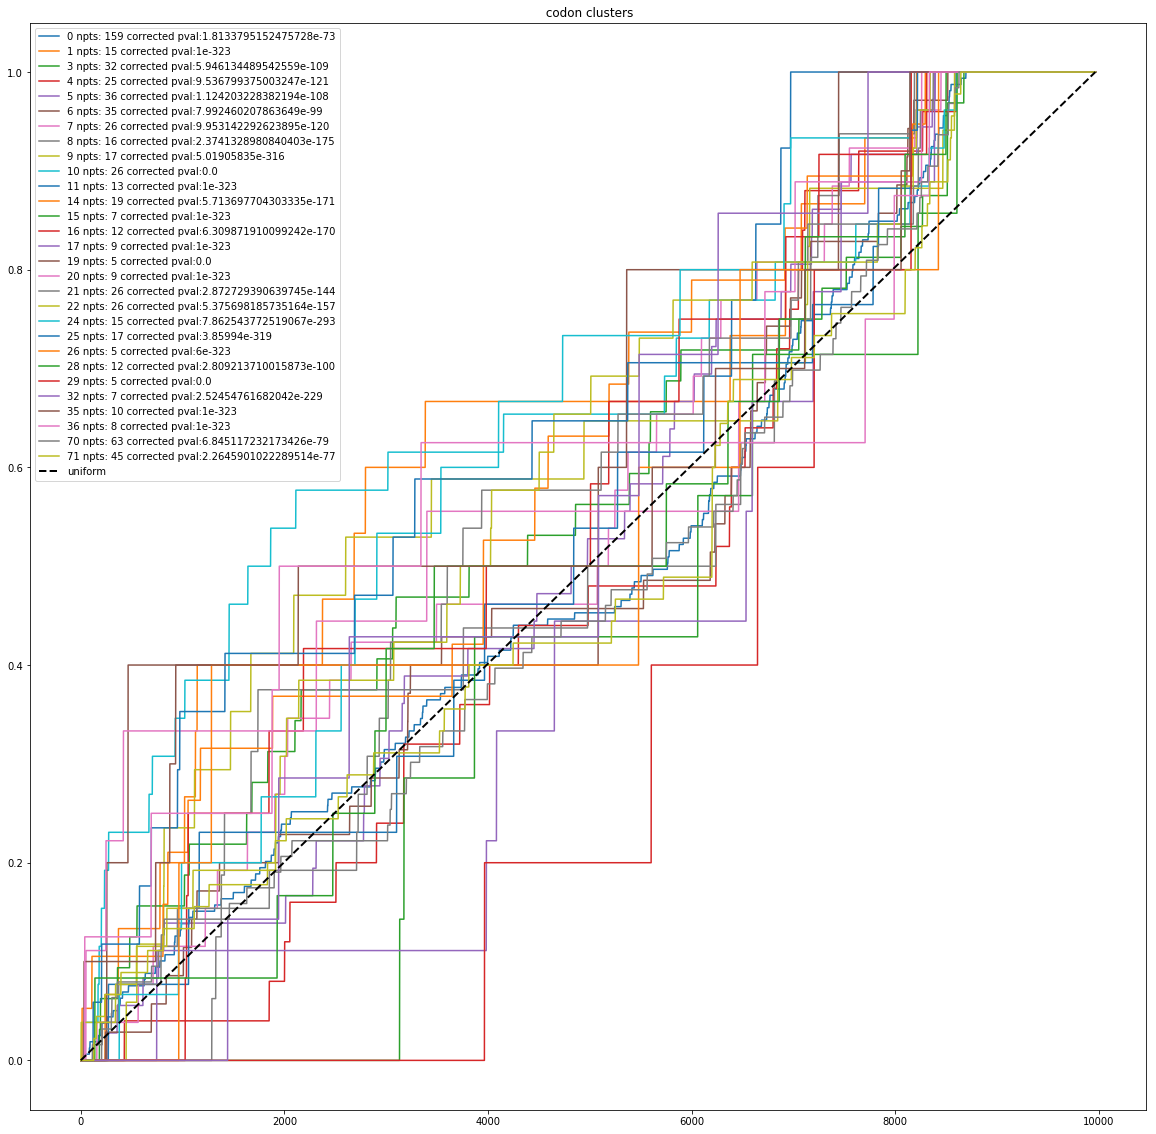

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), array([5.25880059e-072, 2.86558075e-322, 1.72437900e-107, 2.76567182e-119,
       3.26018936e-107, 2.31781346e-097, 2.88641126e-118, 6.88498540e-174,
       1.45552692e-314, 0.00000000e+000, 2.86558075e-322, 1.65697233e-169,
       2.86558075e-322, 1.82986285e-168, 2.86558075e-322, 0.00000000e+000,
       2.86558075e-322, 8.33091523e-143, 1.55895247e-155, 2.28013769e-291,
       1.11938181e-317, 1.71934845e-321, 8.14671976e-099, 0.00000000e+000,
       7.32118809e-228, 2.86558075e-322, 2.86558075e-322, 1.98508400e-077,
       6.56731130e-076]), 0.0017671710005495722, 0.001724137931034483)


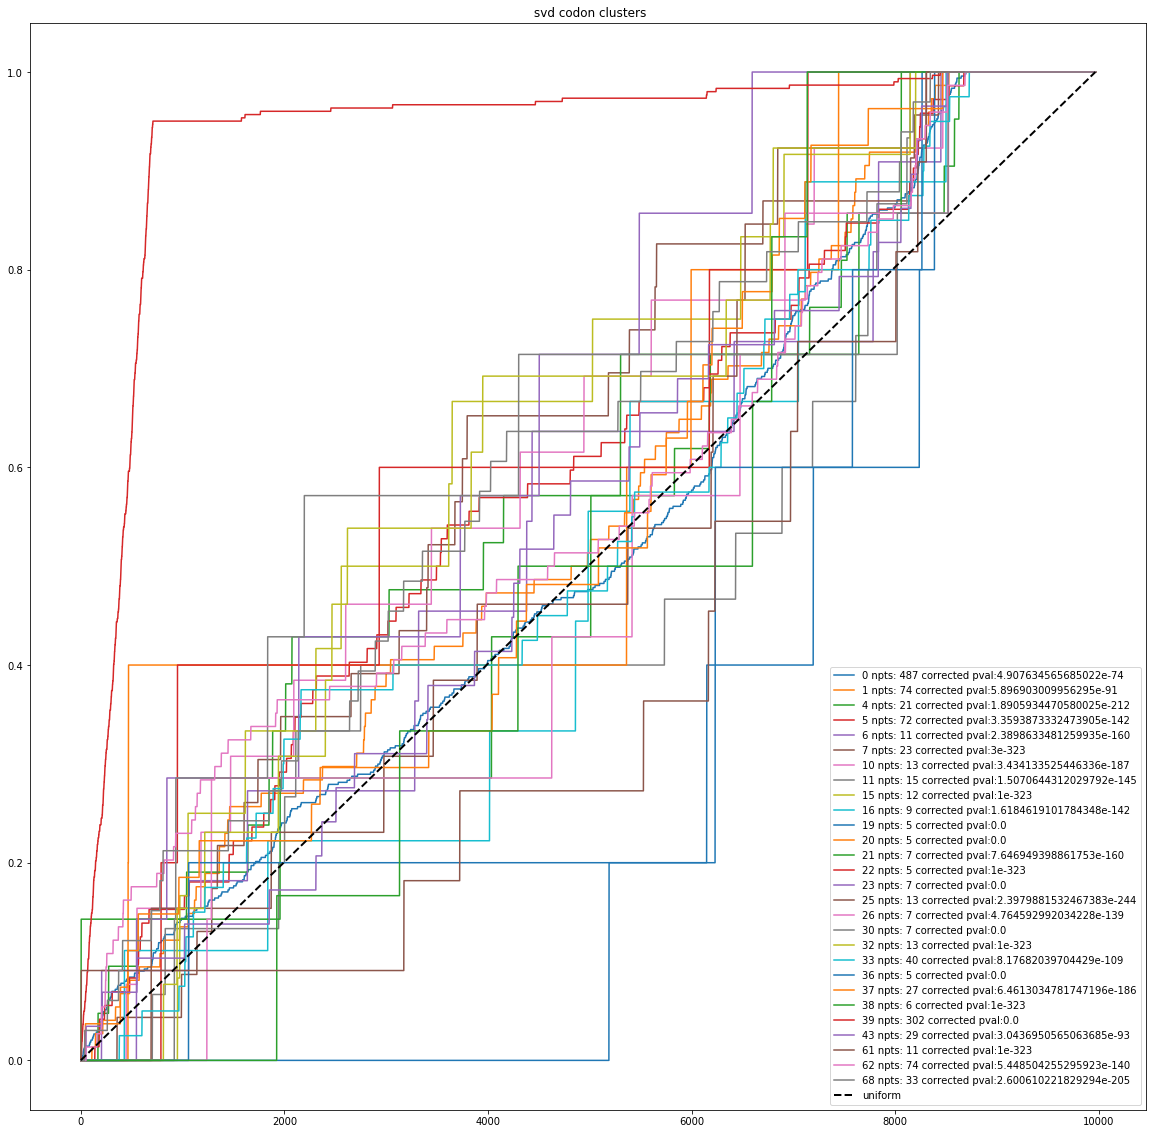

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([1.37413768e-072, 1.65113284e-089, 5.29366165e-211, 9.40628453e-141,
       6.69161737e-159, 8.30030285e-322, 9.61557387e-186, 4.21978041e-144,
       2.76676762e-322, 4.53169335e-141, 0.00000000e+000, 0.00000000e+000,
       2.14114583e-158, 2.76676762e-322, 0.00000000e+000, 6.71436683e-243,
       1.33408604e-137, 0.00000000e+000, 2.76676762e-322, 2.28950971e-107,
       0.00000000e+000, 1.80916497e-184, 2.76676762e-322, 0.00000000e+000,
       8.52234616e-092, 2.76676762e-322, 1.52558119e-138, 7.28170862e-204]), 0.001830226460139528, 0.0017857142857142859)


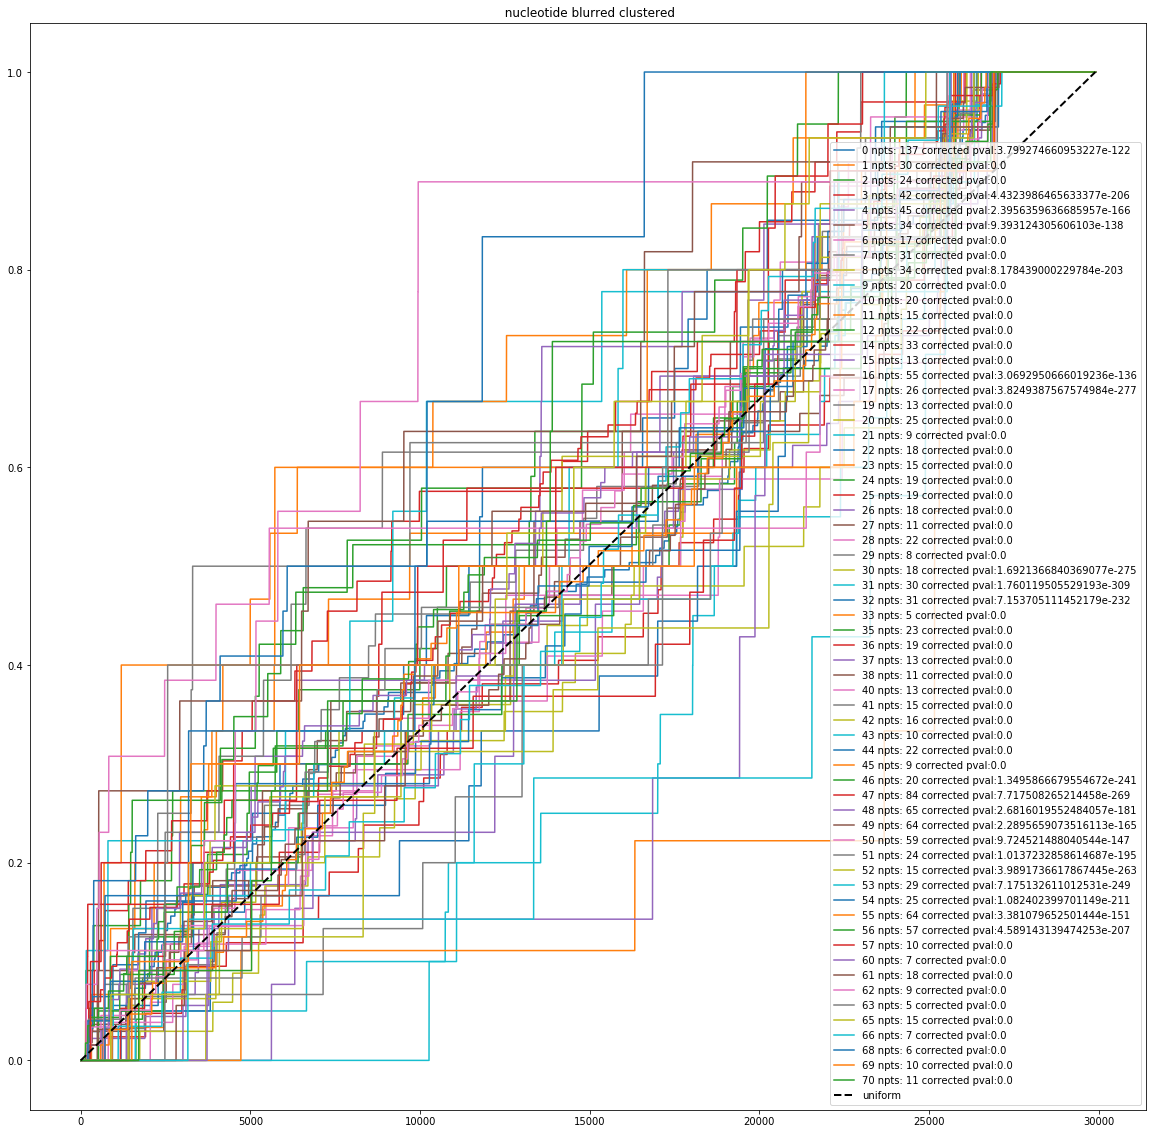

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True]), array([2.39354304e-120, 0.00000000e+000, 0.00000000e+000, 2.79241115e-204,
       1.50925066e-164, 5.91766831e-136, 0.00000000e+000, 0.00000000e+000,
       5.15241657e-201, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.93365589e-134,
       2.40971142e-275, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000,

In [205]:
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
#over the whole genome
titles = ' codon clusters, svd codon clusters,  nucleotide blurred clustered '.split(',')
for k,cluster_labels in enumerate([ cluster_labels_codon , cluster_labels_reduced , cluster_labels_raw ]):
    bonferroni = []
    plots = []
    plotlabels=[]
    plt.figure( figsize=(20,20))
    cdf_uniform = np.cumsum(np.ones(len(cluster_labels)) ) / np.sum(np.ones(len(cluster_labels)) )
    for i,label in enumerate(np.unique(cluster_labels_raw)):
        cluster_ones = np.zeros(len(cluster_labels))        
        cluster_ones[ cluster_labels==label ] = 1
        if np.sum(cluster_ones) > 4 and np.sum(cluster_ones) < 1000 :
            cdf_empirical= np.cumsum(cluster_ones) / np.sum(cluster_ones)
            res = stats.ks_2samp(cdf_empirical, cdf_uniform)
            fig = plt.plot( cdf_empirical )
            plots.append(fig)
            plotlabels.append( str(label) +  ' npts: '+ str(int( np.sum(cluster_ones)) ) )  
            bonferroni.append(res[1])
    plt.plot(cdf_uniform, lw = 2 , ls = 'dashed' , c = 'black' )
    
    plotlabels = [ str(p) + ' corrected pval:' + str(bonferroni[ i ]) for i,p in enumerate( plotlabels ) ]+['uniform']
    plt.legend( plotlabels )
    plt.title( titles[k])
    plt.show()
    bf_correction = multipletests(bonferroni, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
    print(bf_correction)

In [ ]:
clusterdf = { label : [ codon_dict_rev[p] for p in list( np.where(cluster_labelsb == label )[0]  ) if p in codon_dict_rev ] for i,label in enumerate(list(l)) if c[i]< 300 and c[i]> 1 } 
clusterdf = pd.DataFrame.from_dict( clusterdf , orient = 'index' , dtype=pd.Int64Dtype() )

print( clusterdf )
print(clusterdf.index)

clusterdf.to_csv( alnfile + 'clusterpositions_columns.csv')

In [ ]:
protstart = {}
protend = {}
position = 0
for i,r in annotation.iterrows():
    protstart[i] = position 
    position += len( r.prots )
    protend[i] = position
annotation['codon_start'] = annotation.index.map( protstart )
annotation['codon_end'] = annotation.index.map( protend )
print(annotation)

In [176]:
import json
titles = ' codon clusters, svd codon clusters'.split(',')

for k,cluster_labels in enumerate([ cluster_labels_codon , cluster_labels_reduced ]):
    clusters = {}
    for l in np.unique(cluster_labels):
        if len(cluster_labels[ cluster_labels==l ] ) < 200 and len(cluster_labels[ cluster_labels==l ] ) > 4:
            #index of positions
            cluster_postions = np.where( cluster_labels==l )
            for i,r in annotation.iterrows():
                for p in list(cluster_postions[0]):
                    if r.prot_start < p+1 and r.prot_end > p+1:
                        if i not in clusters:
                            clusters[i] = {}
                        if l not in clusters[i]:
                            clusters[i][l] = []
                        clusters[i][l].append(p+1-r.prot_start)
    annotation[titles[k]]= annotation.index.map( clusters )

#annotation['clusters'] = annotation.clusters.map( lambda x : json.dumps( x ) )
print(annotation)

annotation.to_csv('./gisaid/hCoV-19_USA_MA-MGH-00701_2020_EPI ISL 460358_2020-04-06_wclusters.csv')

with open( 'annothack.pkl' , 'wb') as annotout:
    annotout.write(pickle.dumps(annotation))

      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
19  testgeno  YP_009725310.1  29903   346   19621  20658       1   
23  testgeno  YP_009725311.1  29903   298   2065

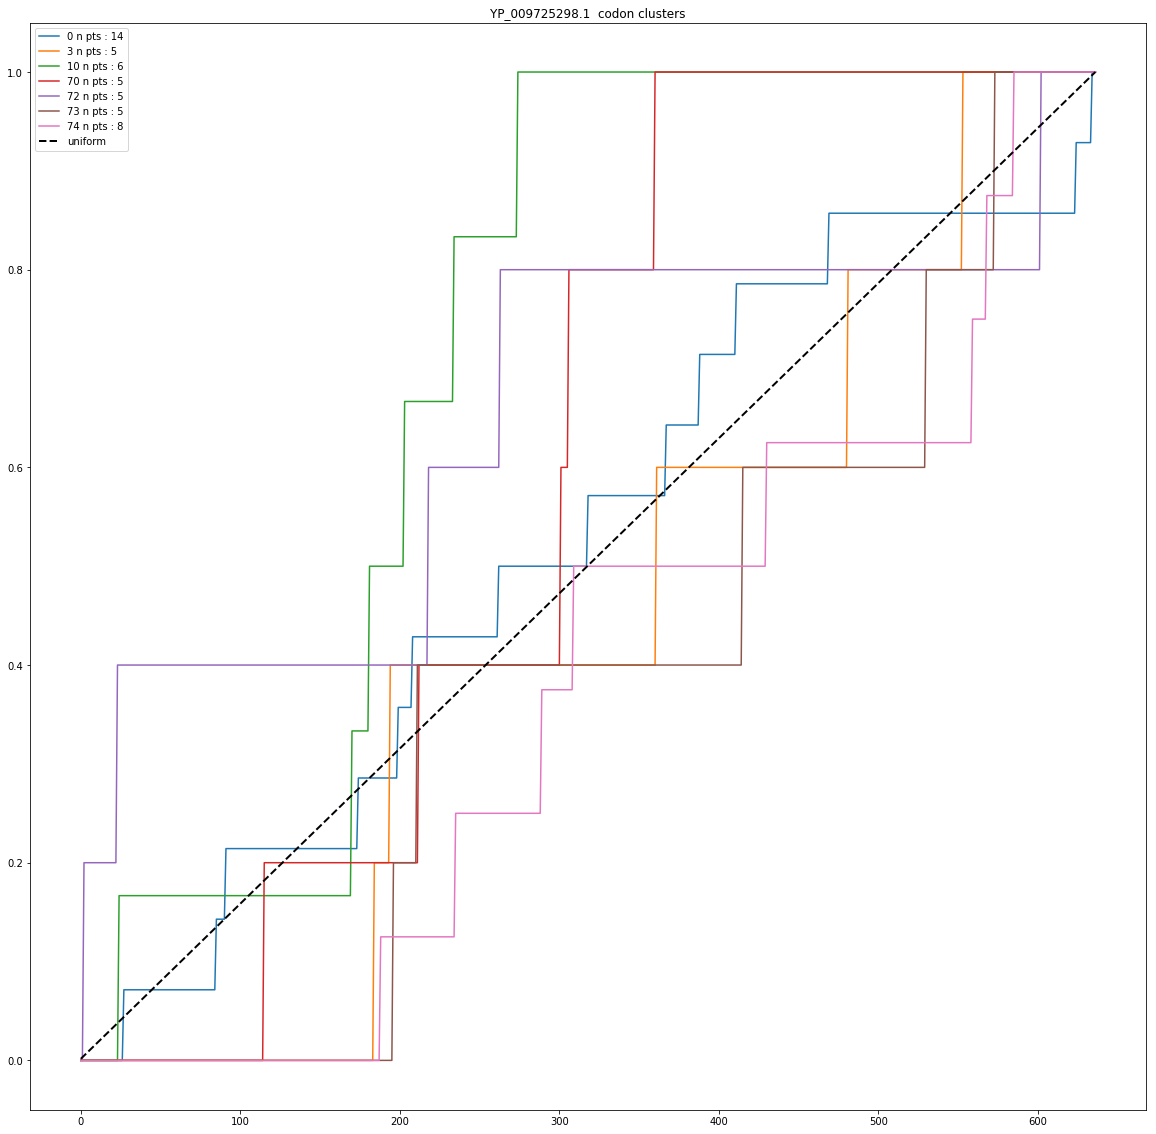

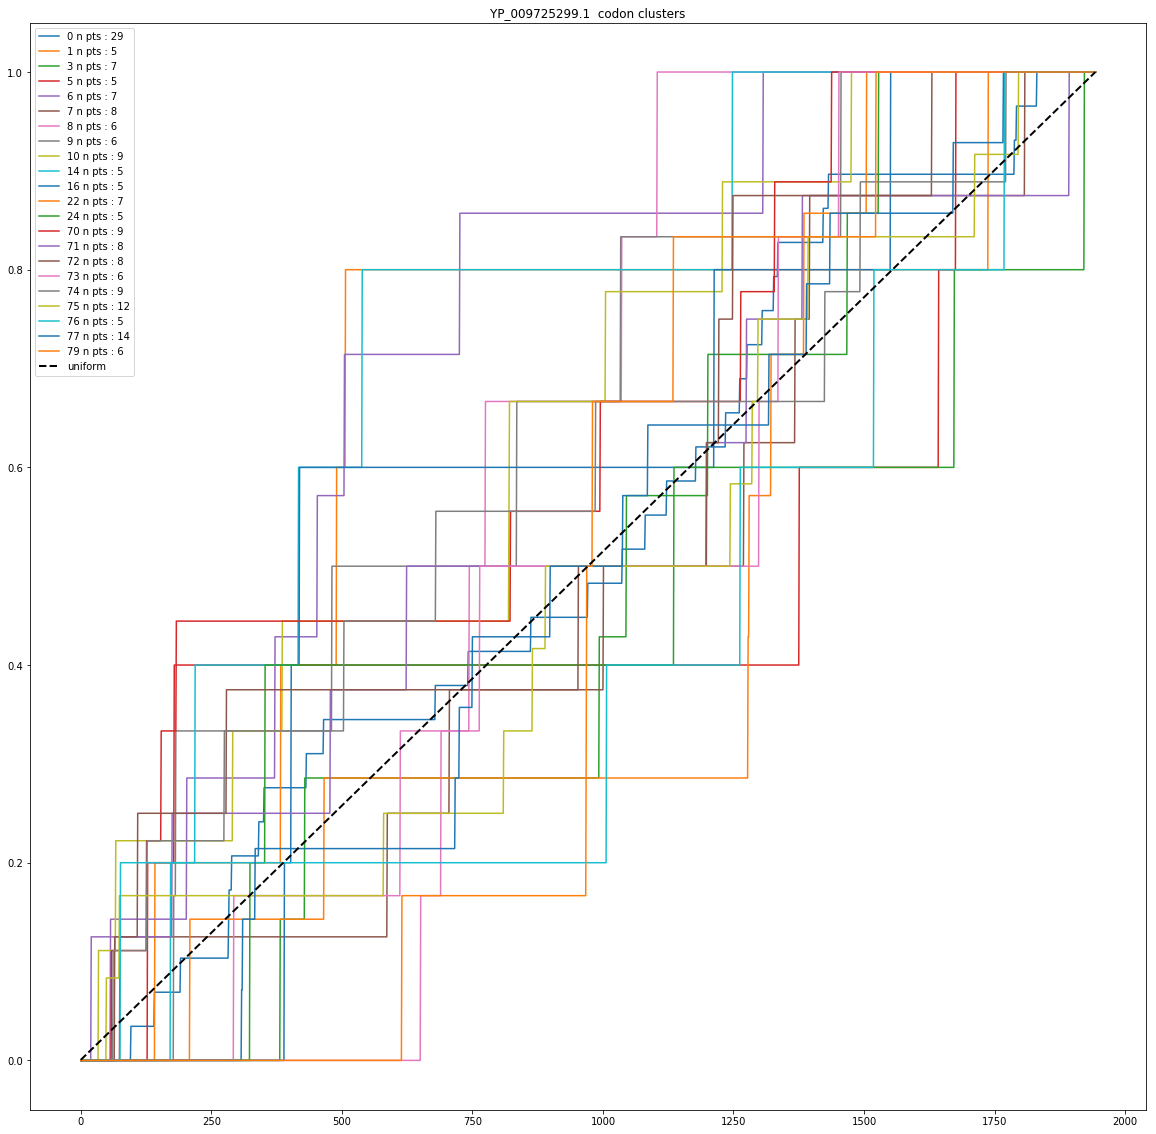

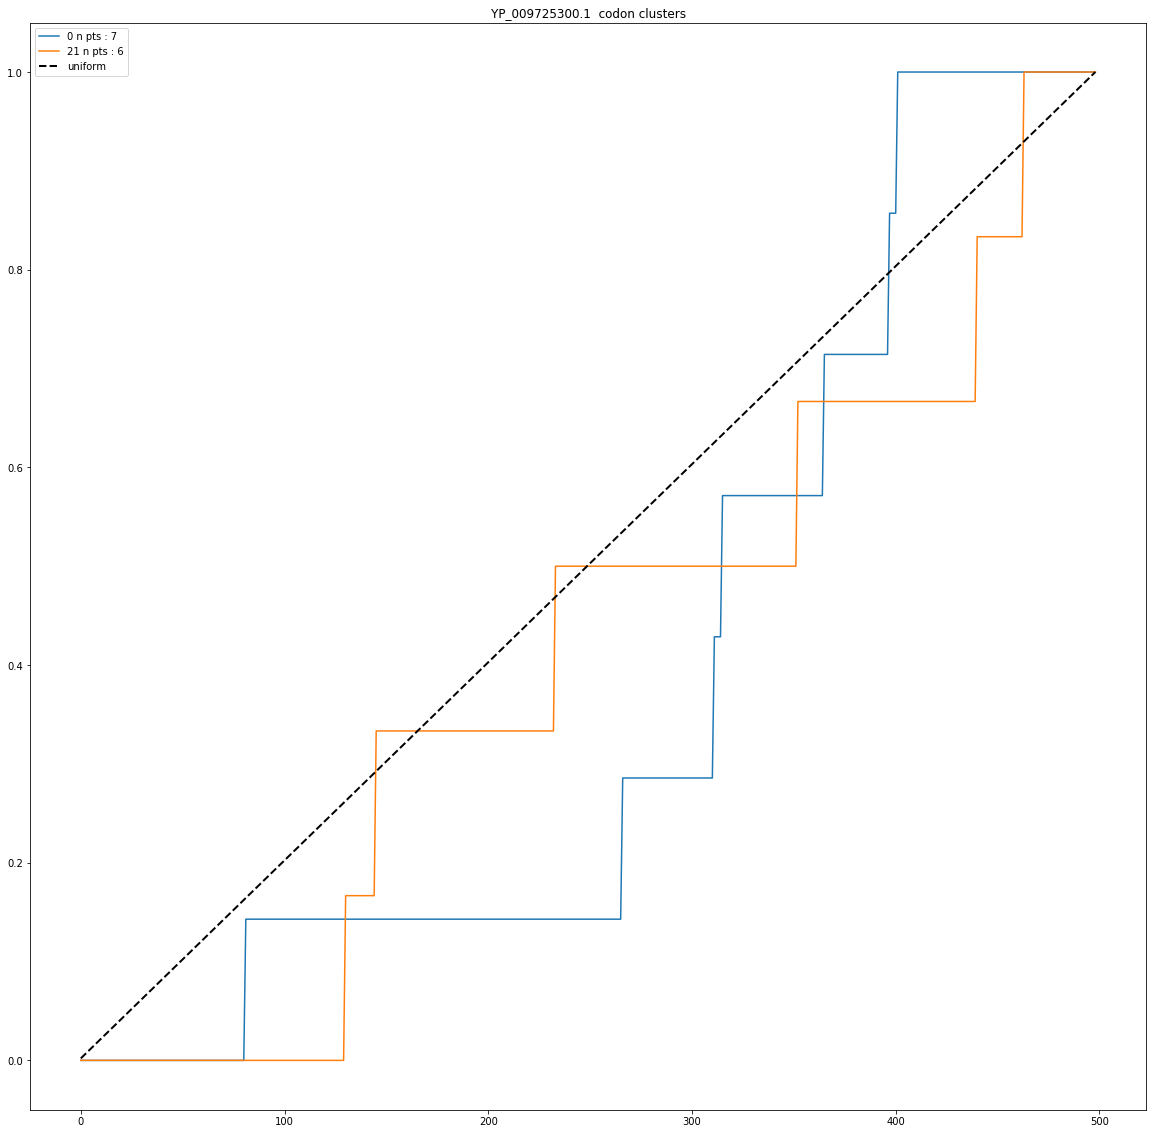

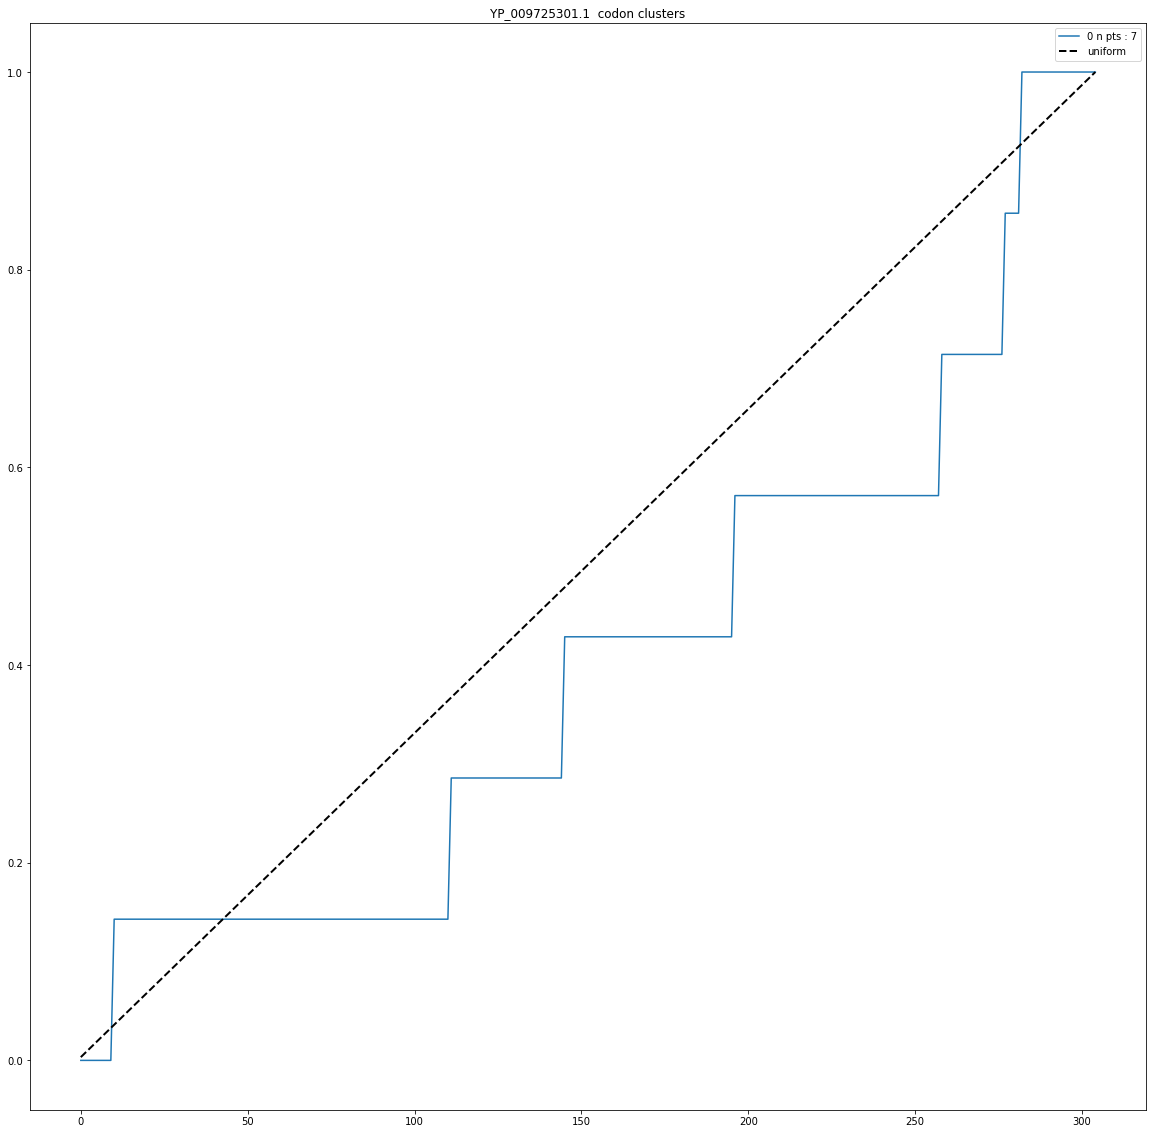

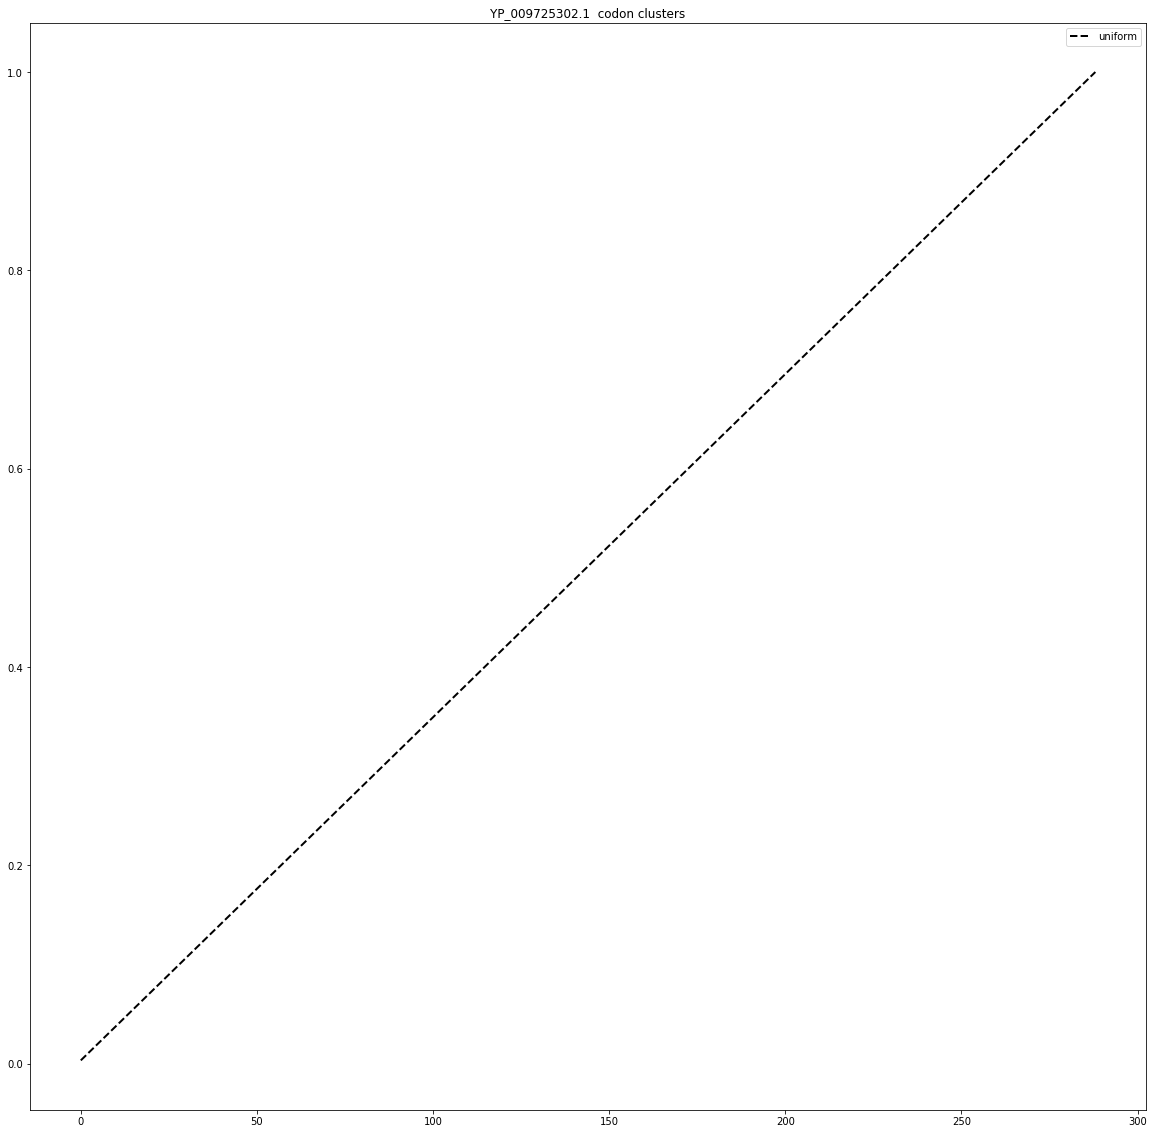

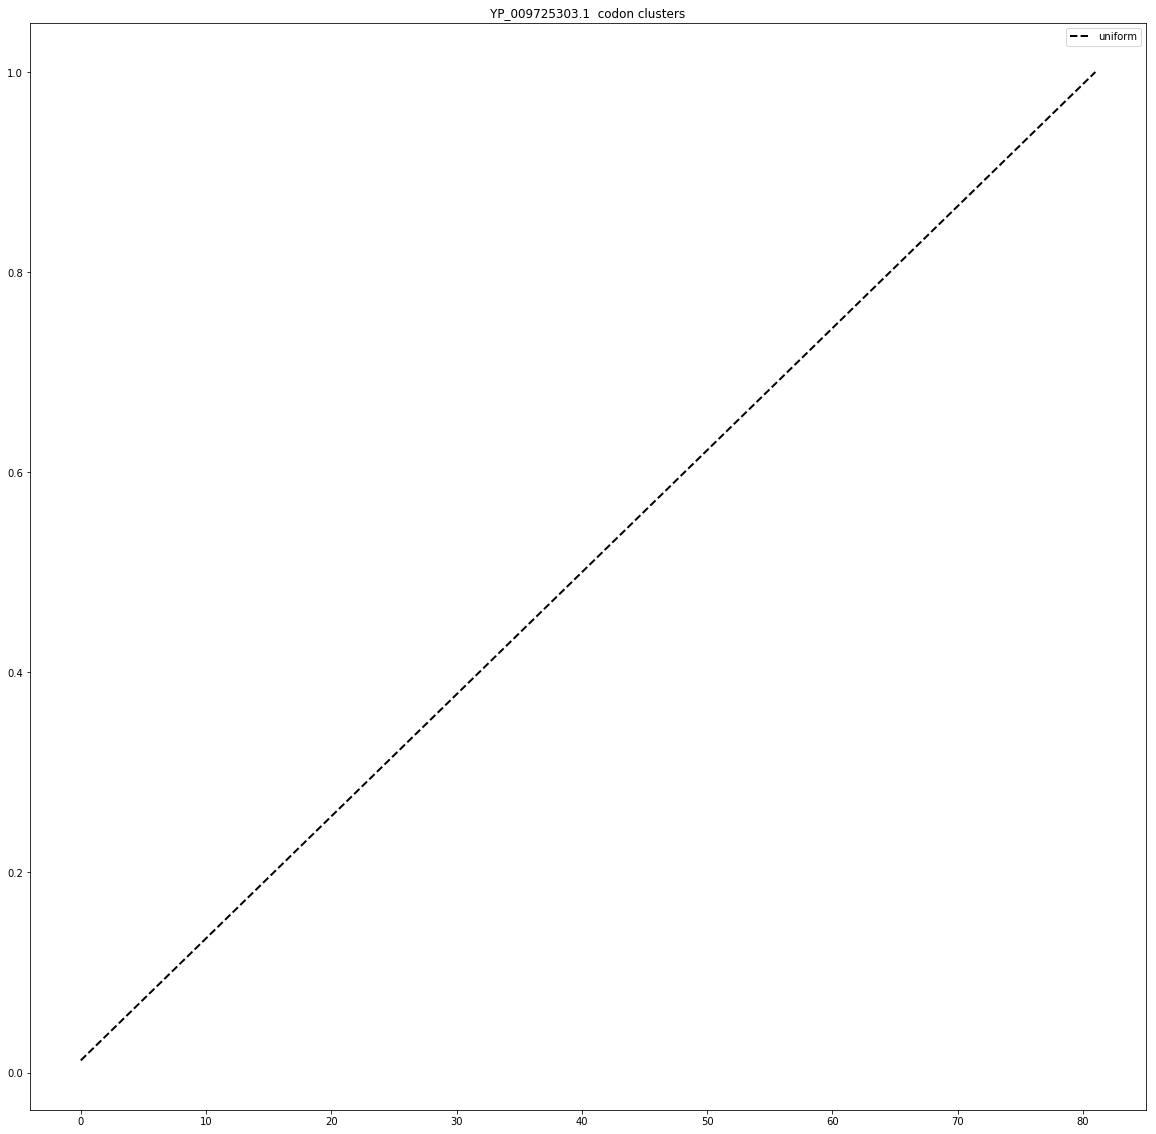

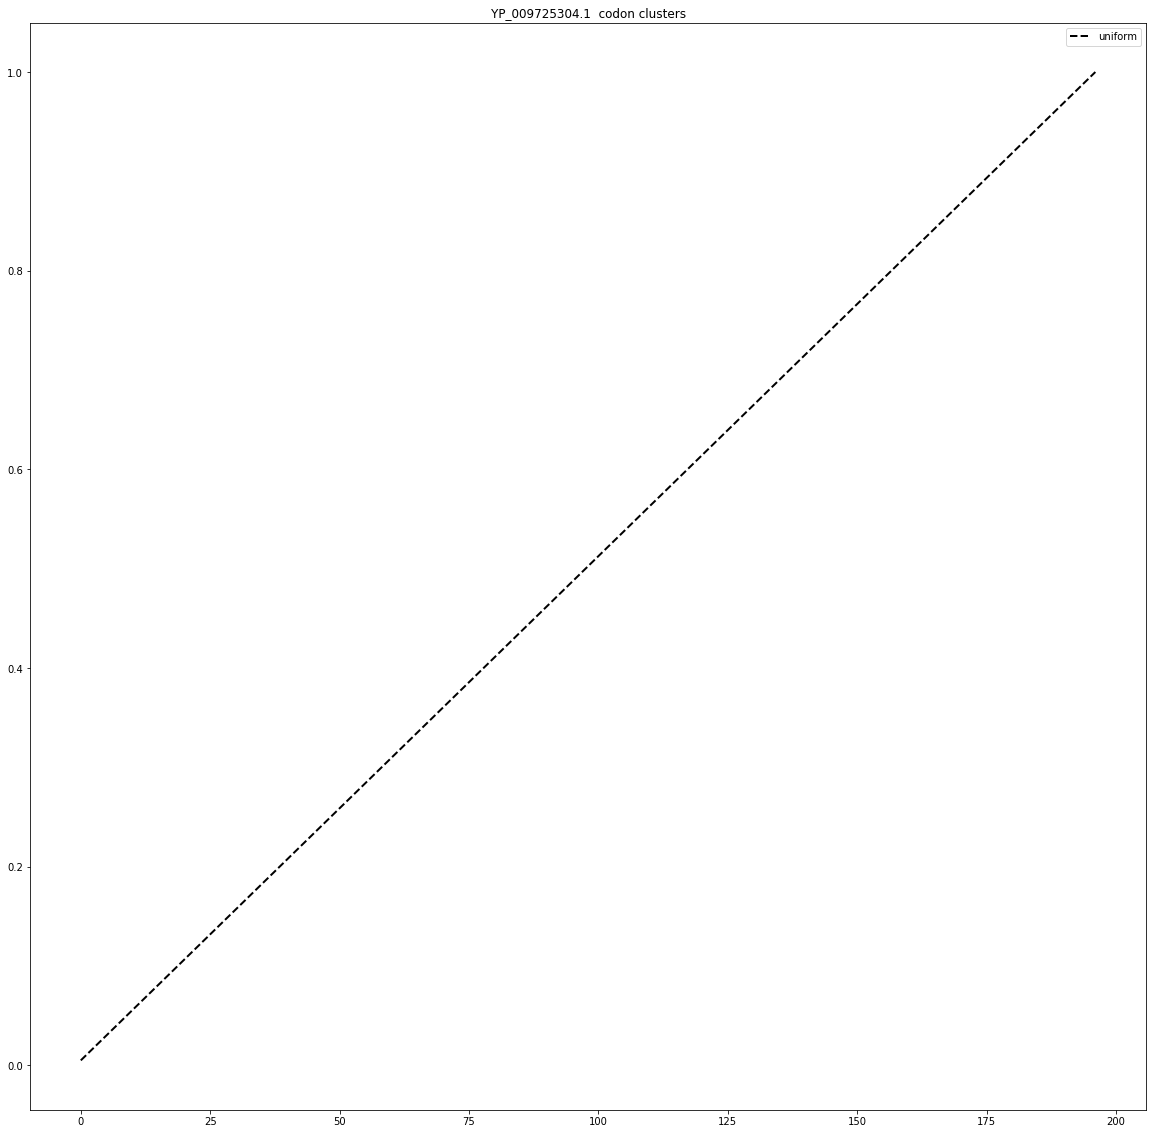

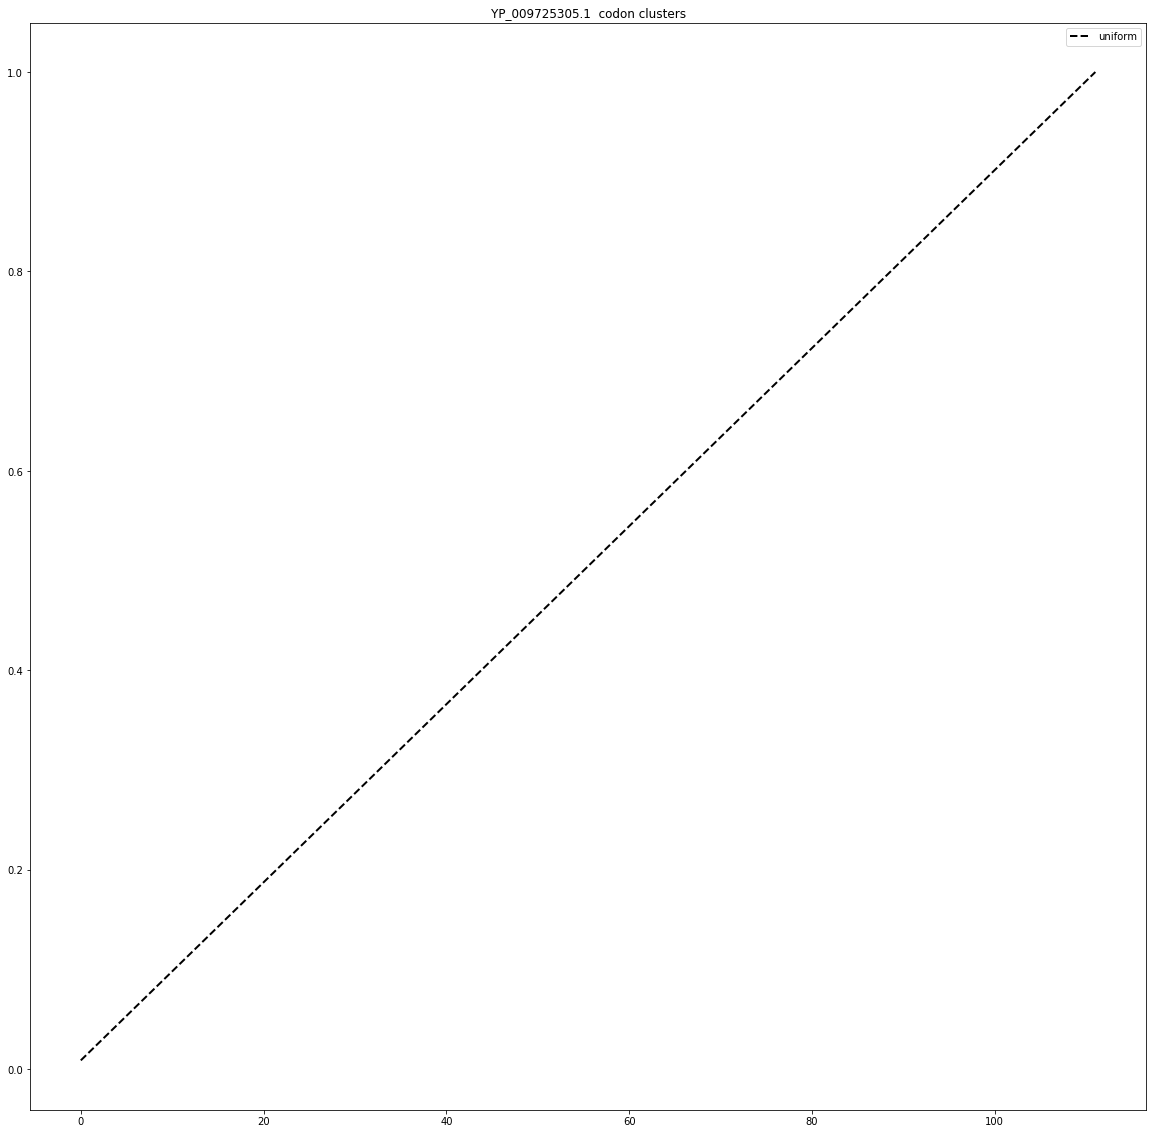

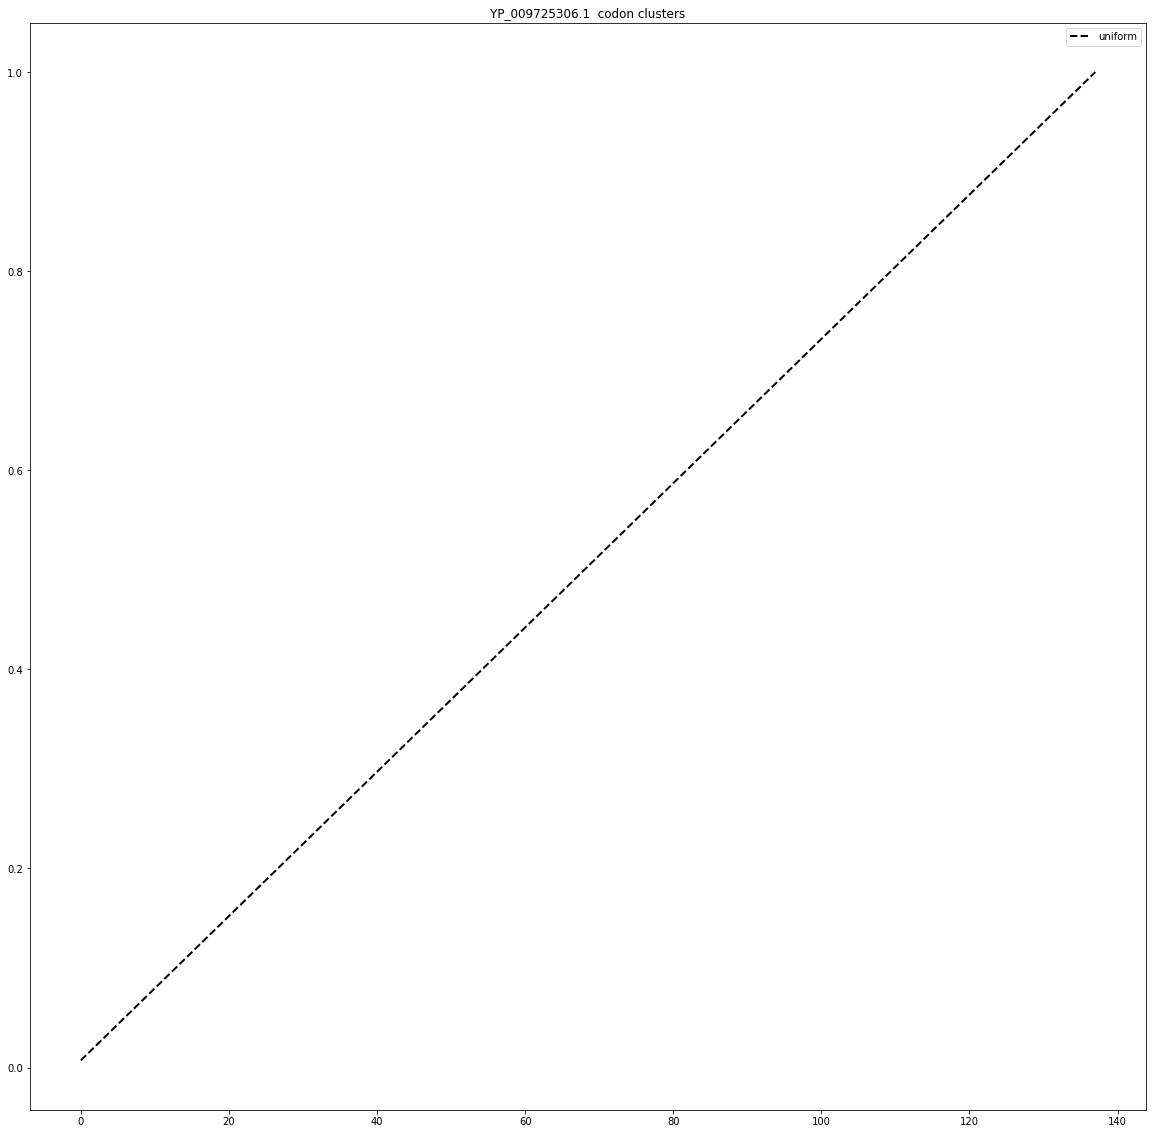

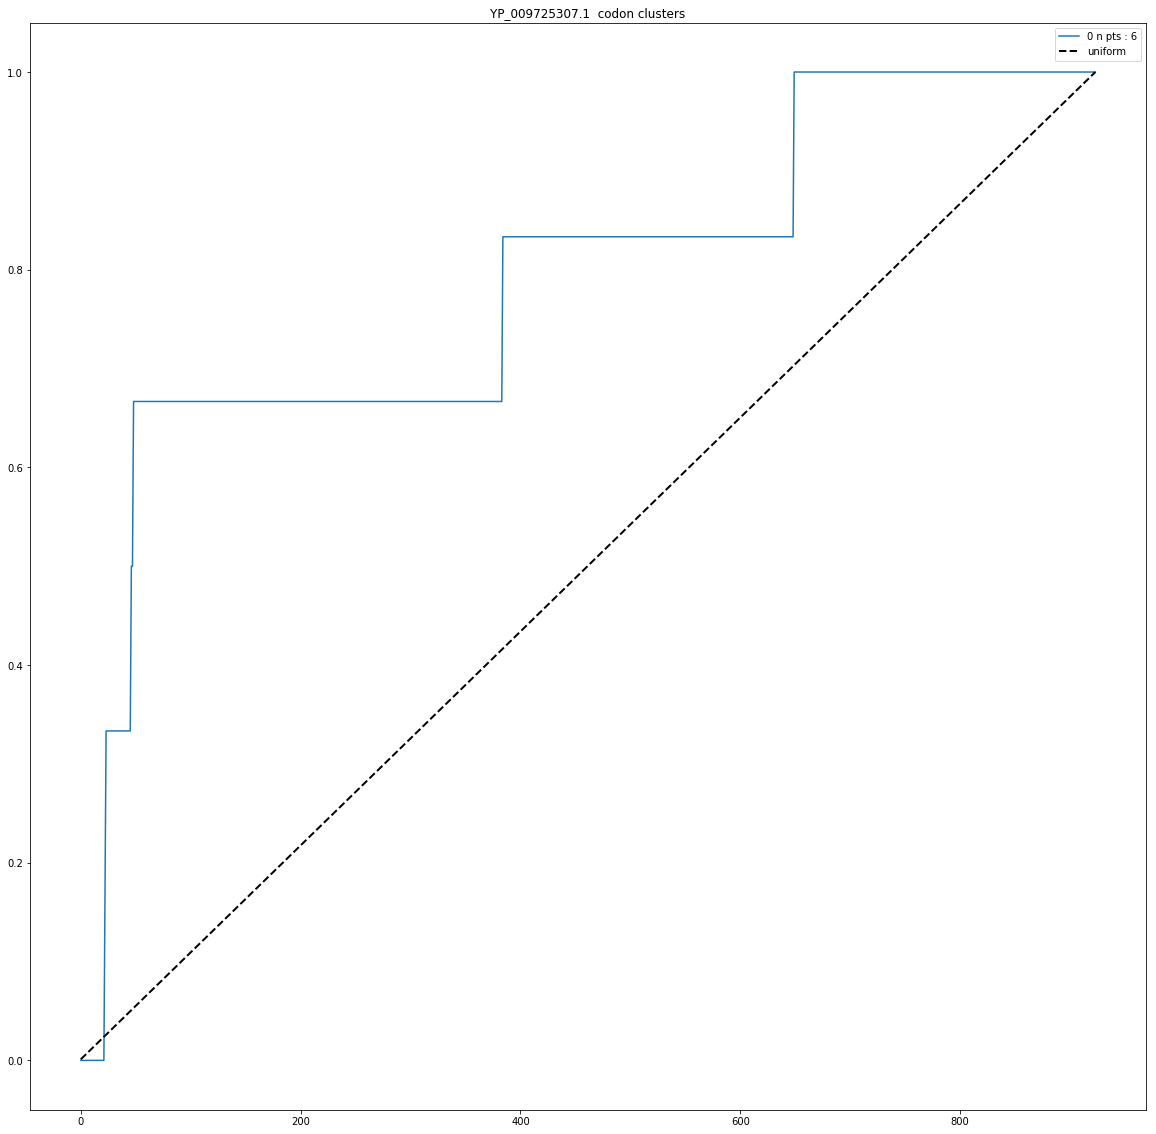

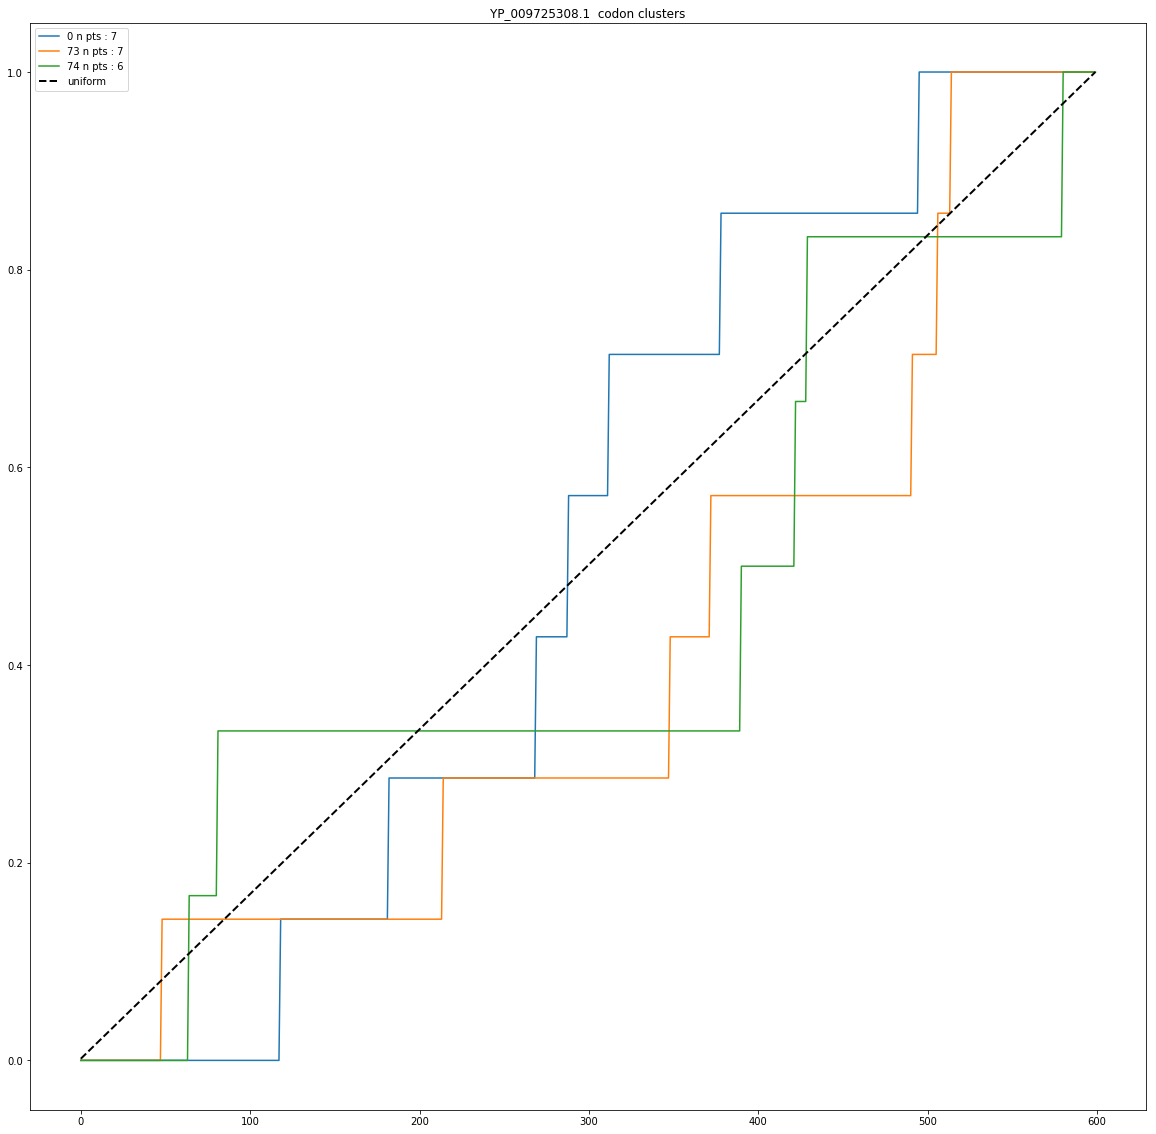

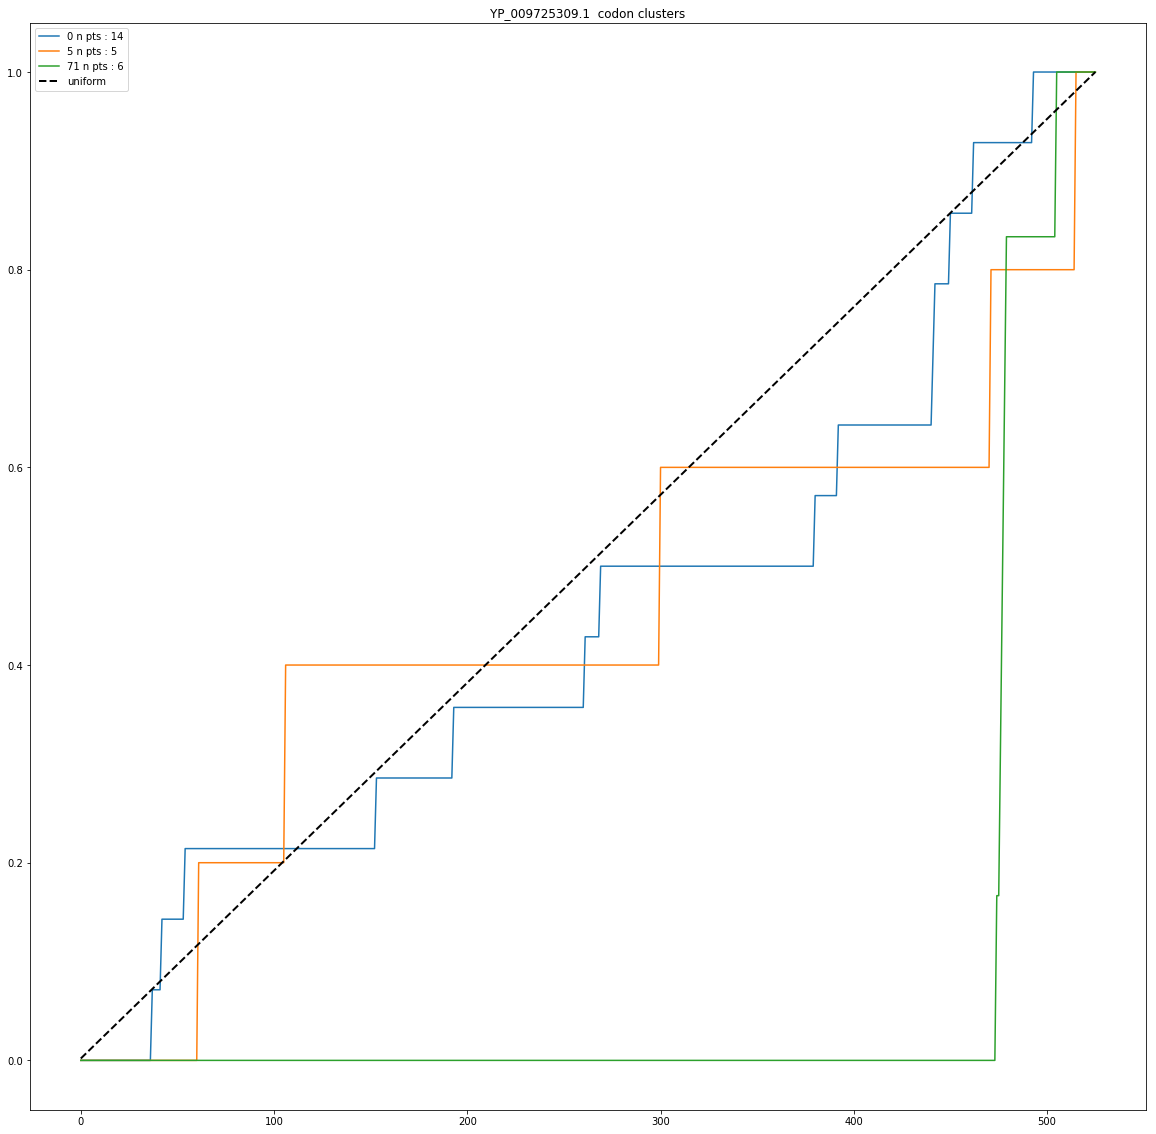

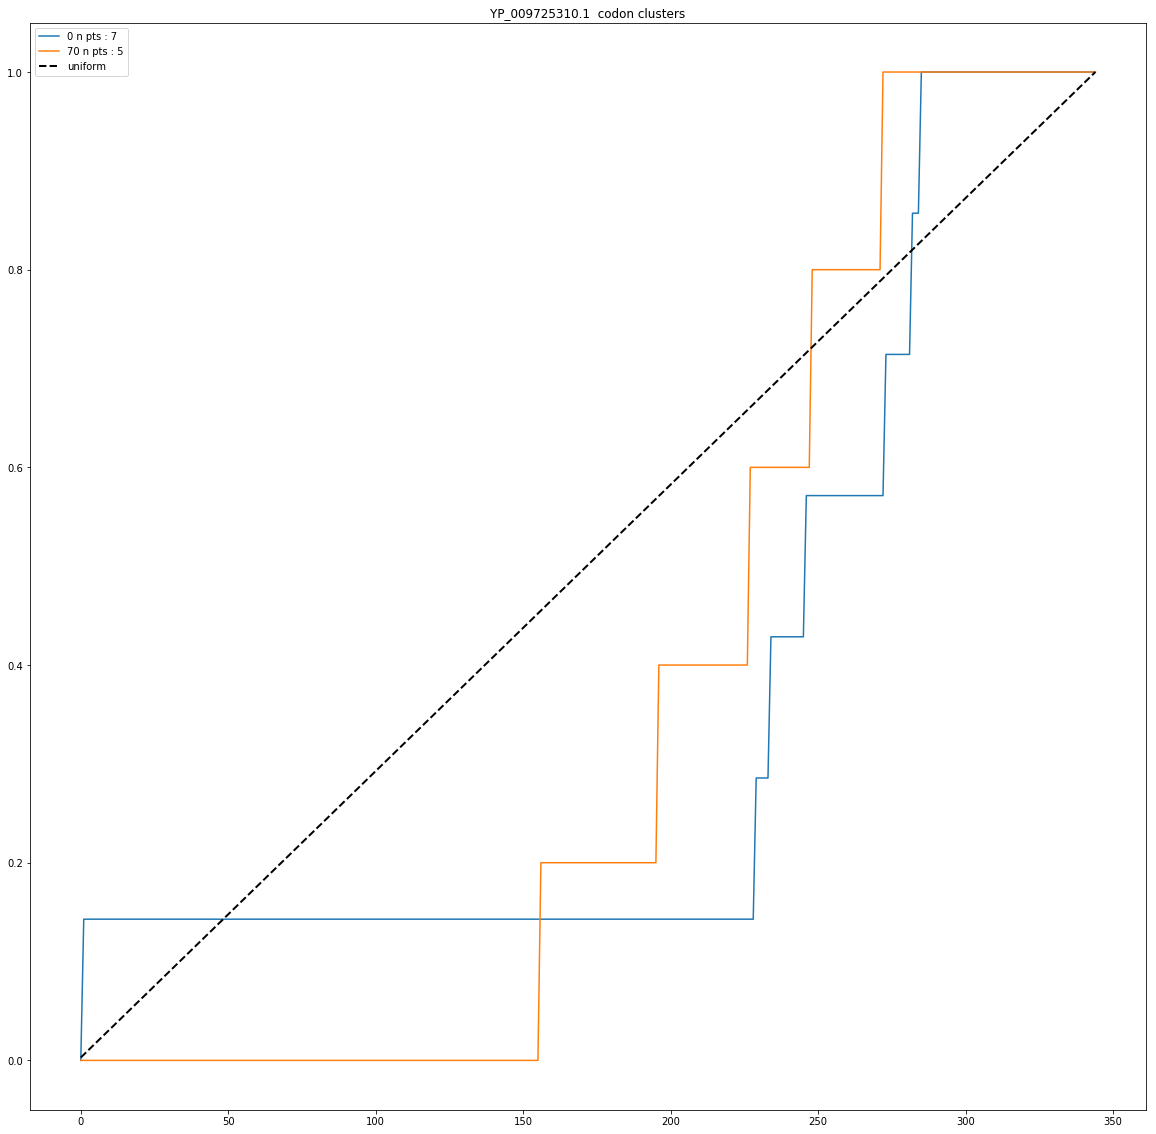

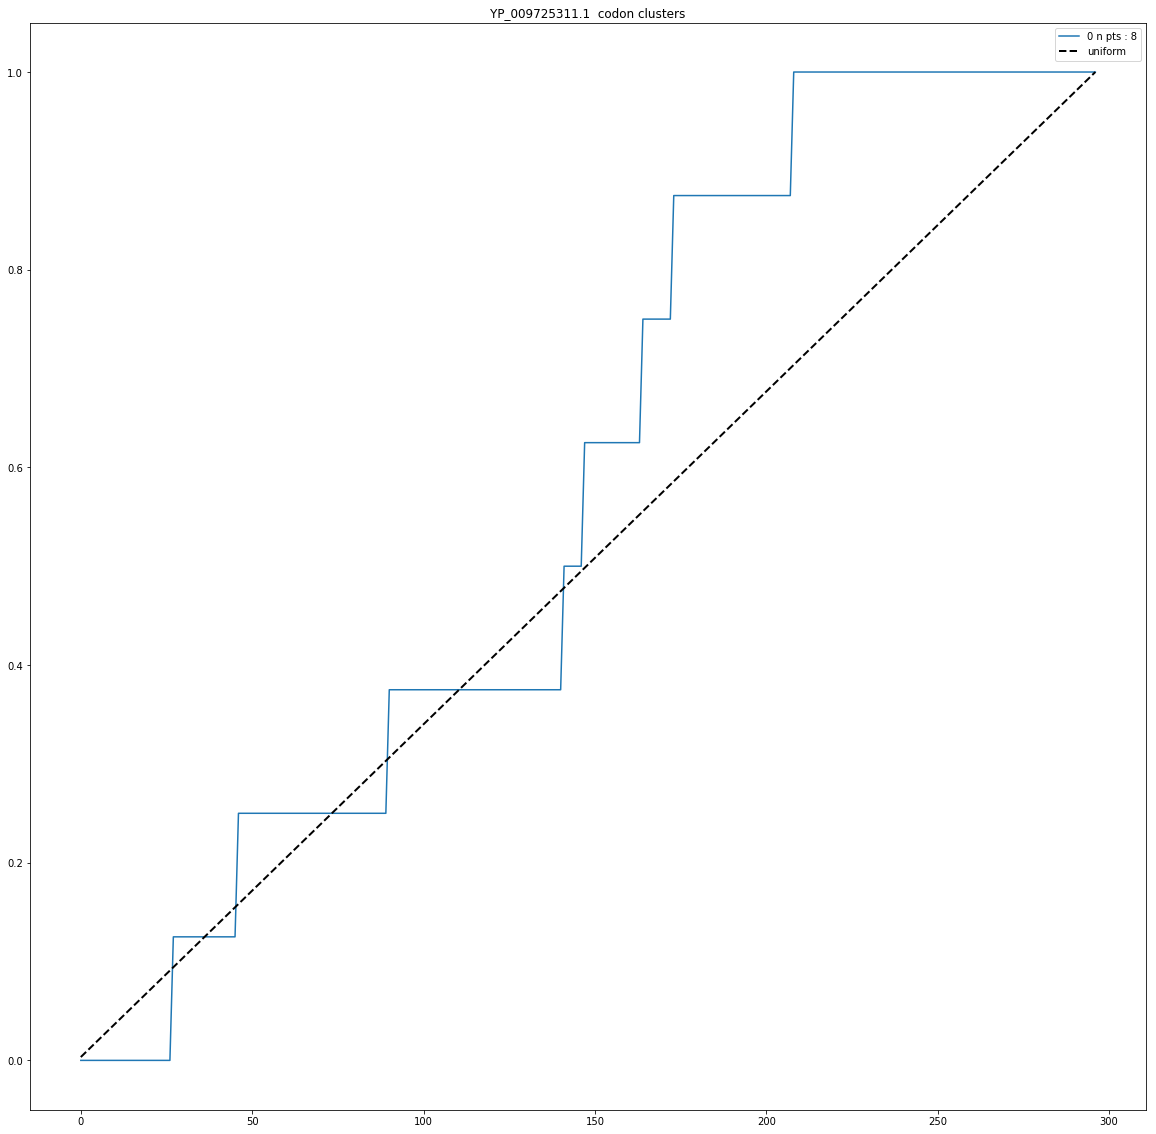

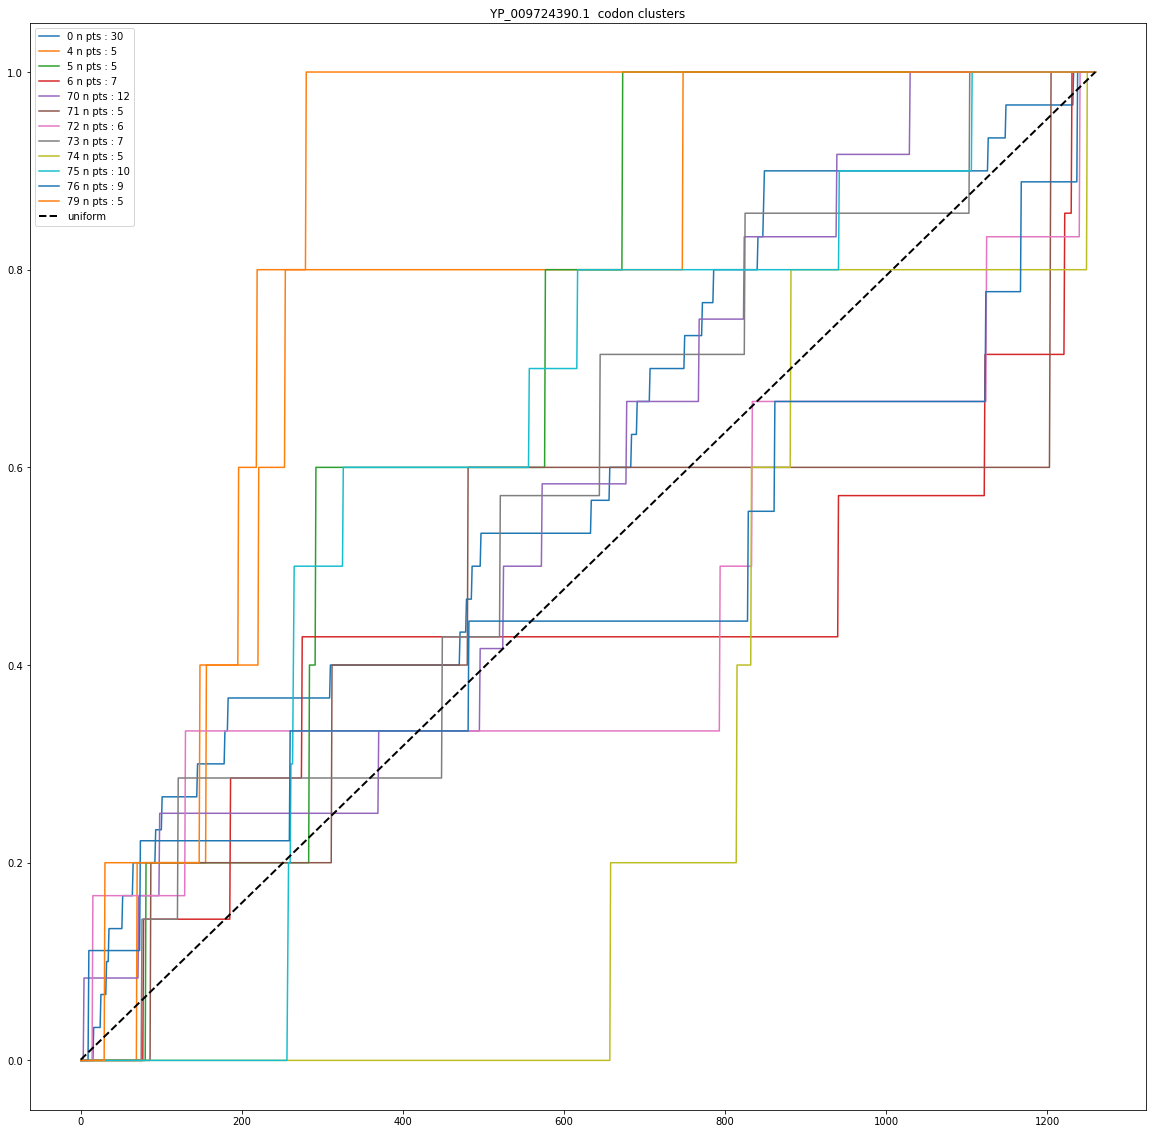

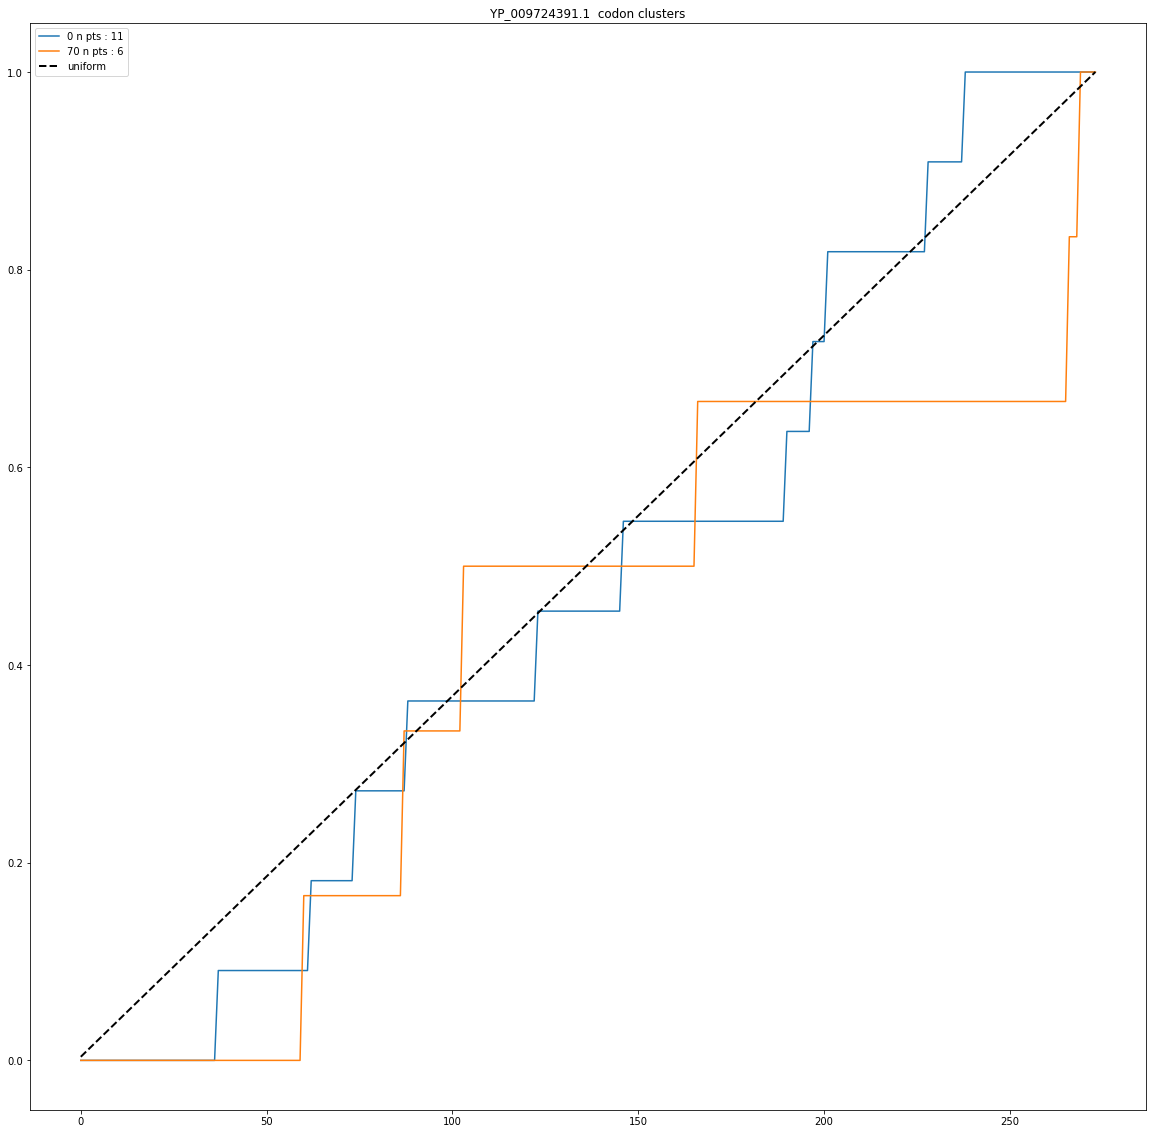

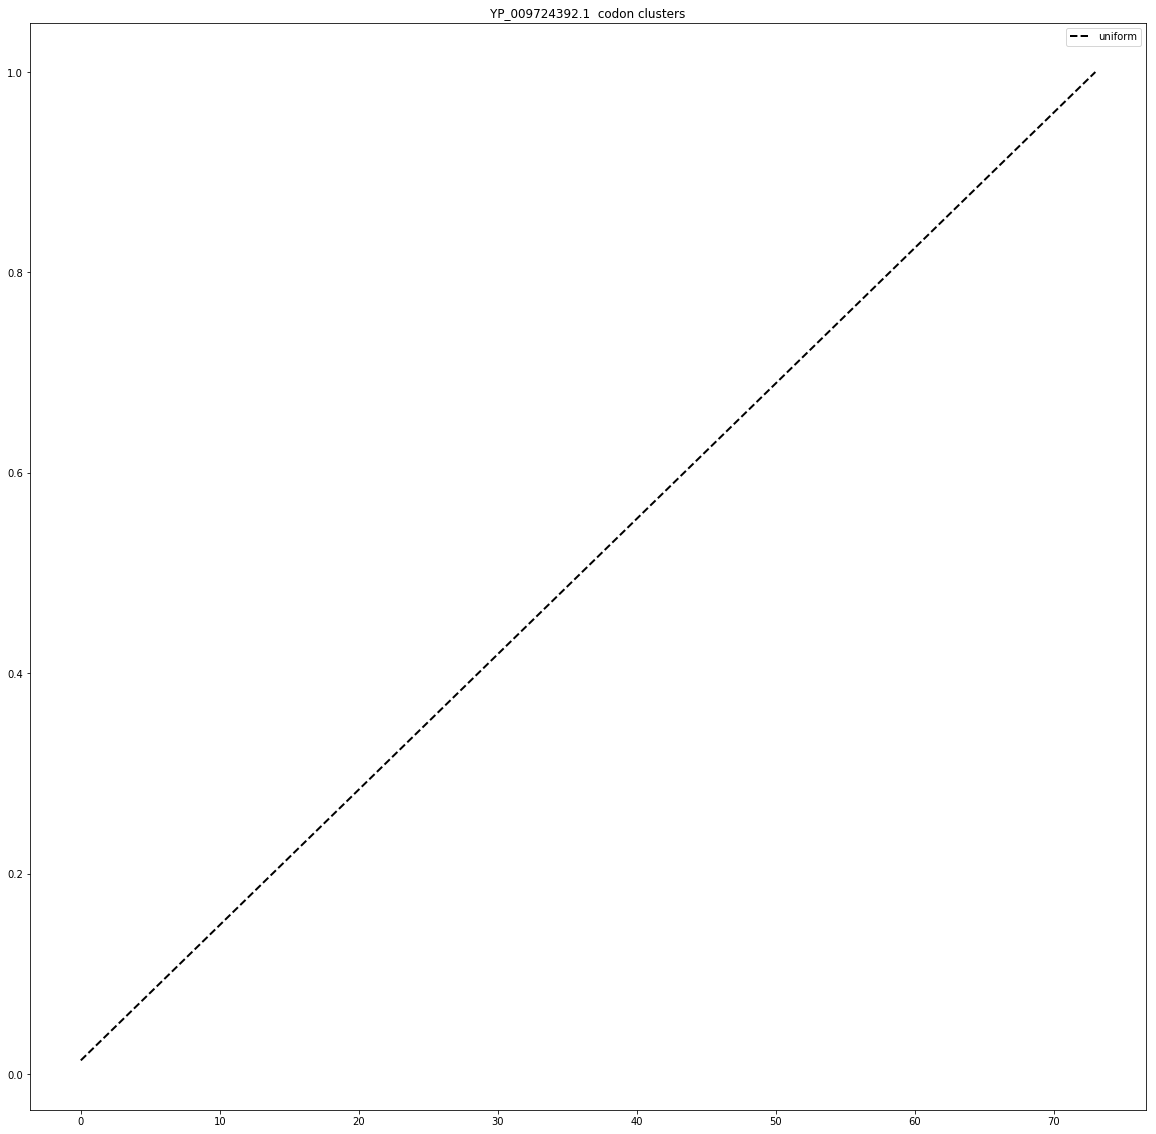

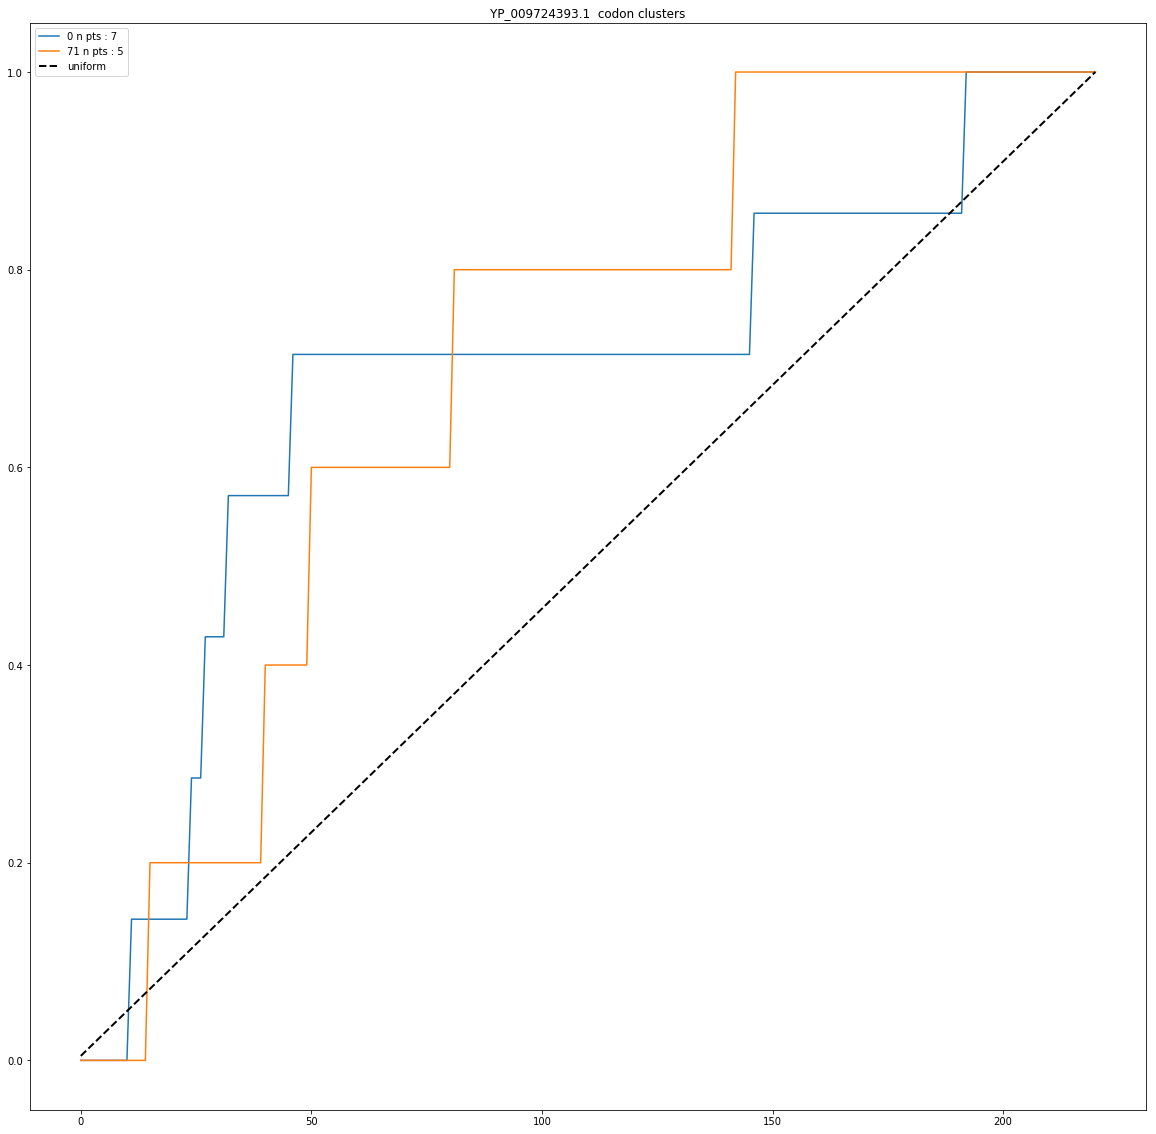

0
(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True]), array([2.35634820e-10, 7.99825678e-43, 7.29200426e-68, 1.01846378e-19,
       0.00000000e+00, 1.31293657e-26, 2.91433274e-22, 1.51034600e-86,
       4.55093803e-23, 2.28985226e-56, 1.27170390e-04, 6.84425222e-52]), 0.004265318777560645, 0.004166666666666667)
3
(array([ True,  True]), array([2.96461368e-47, 1.01520052e-86]), 0.025320565519103666, 0.025)
10
(array([ True,  True]), array([8.16587081e-196, 7.68569485e-117]), 0.025320565519103666, 0.025)
70
(array([ True,  True,  True,  True,  True]), array([2.36299231e-109, 4.50336386e-213, 3.13502833e-064, 8.28545364e-037,
       2.74006640e-022]), 0.010206218313011495, 0.01)
72
(array([ True,  True,  True]), array([5.79965785e-86, 2.02715777e-92, 3.64050791e-98]), 0.016952427508441503, 0.016666666666666666)
73
(array([ True,  True,  True,  True]), array([1.93366693e-053, 1.23369132e-109, 6.13482094e-046, 2.17979114e-045]), 0.01274145509

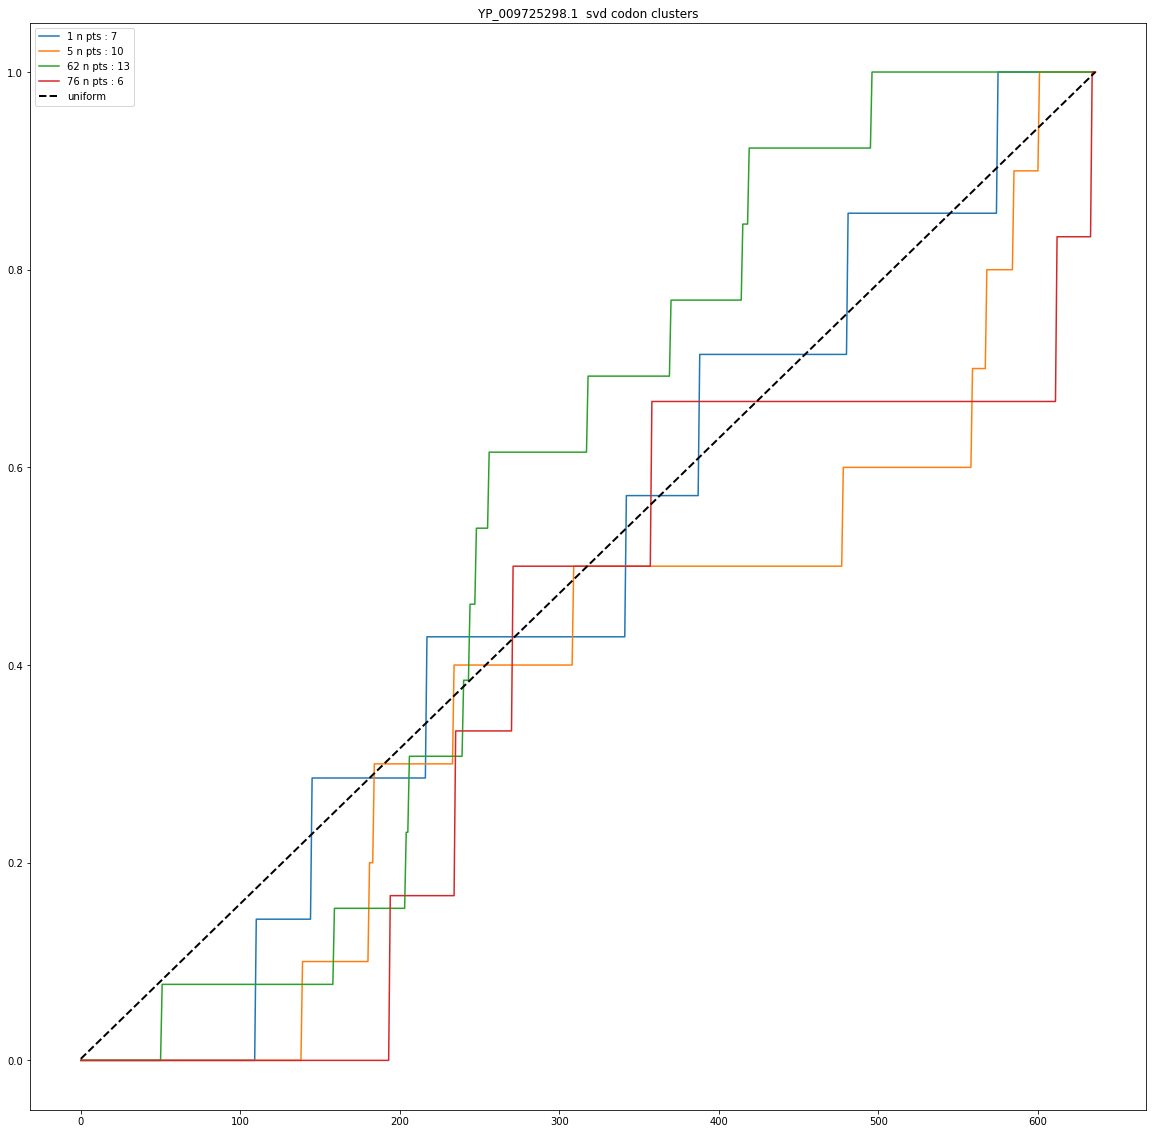

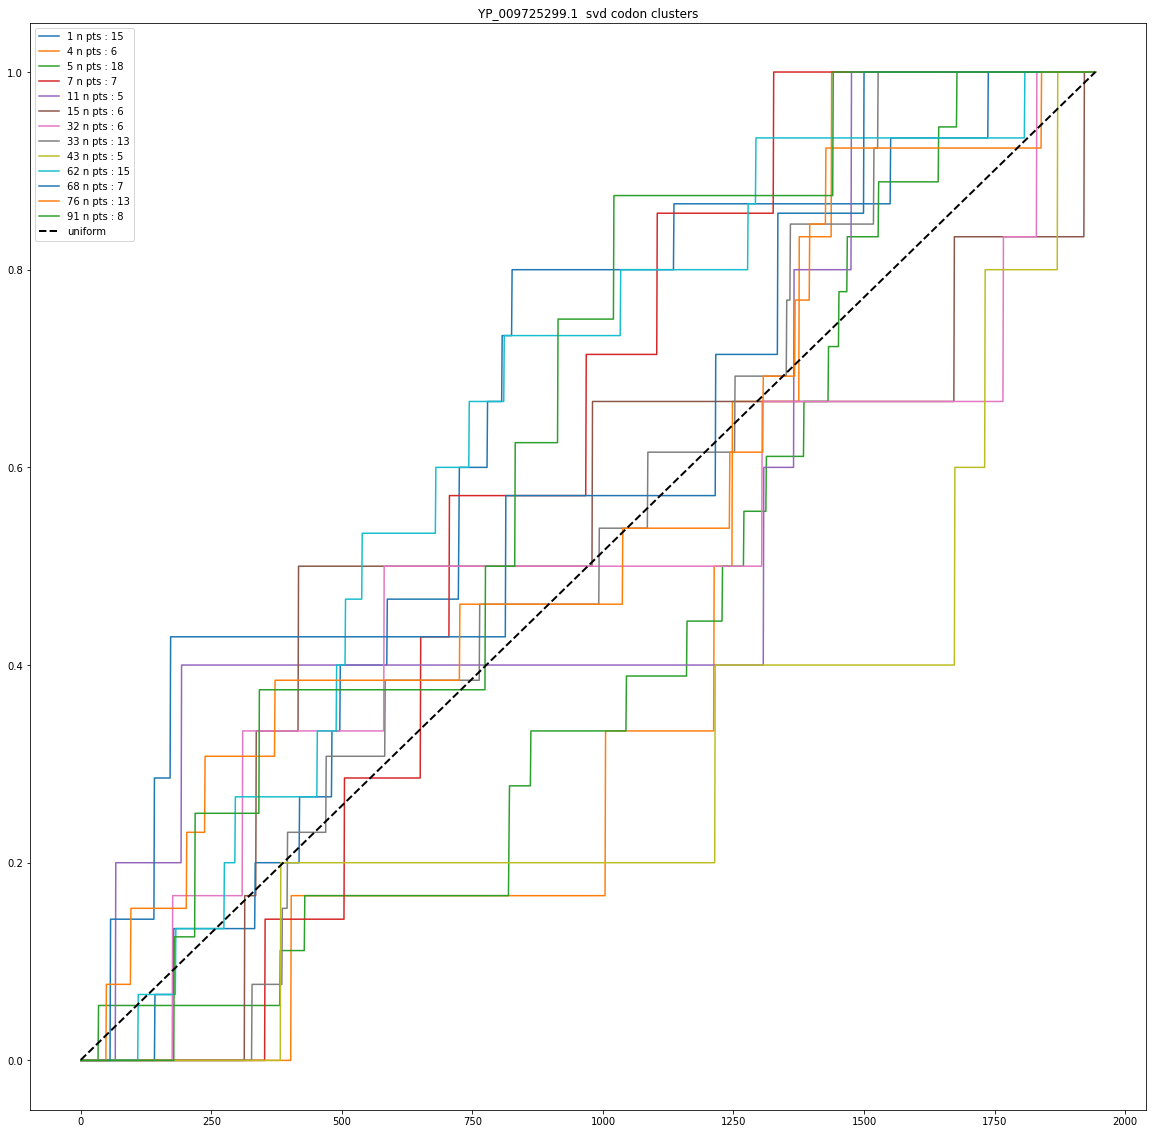

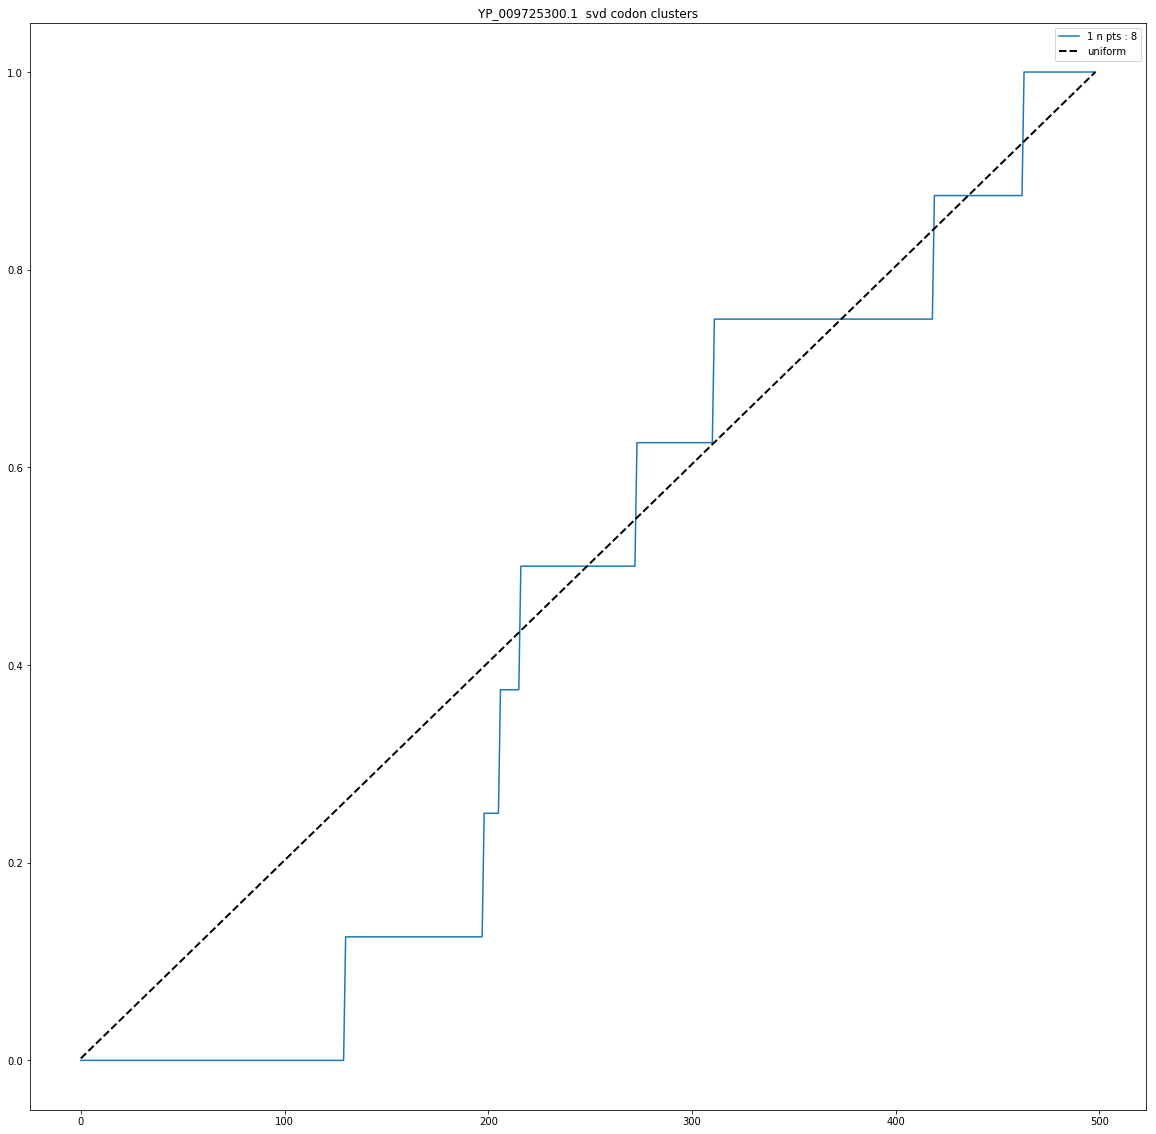

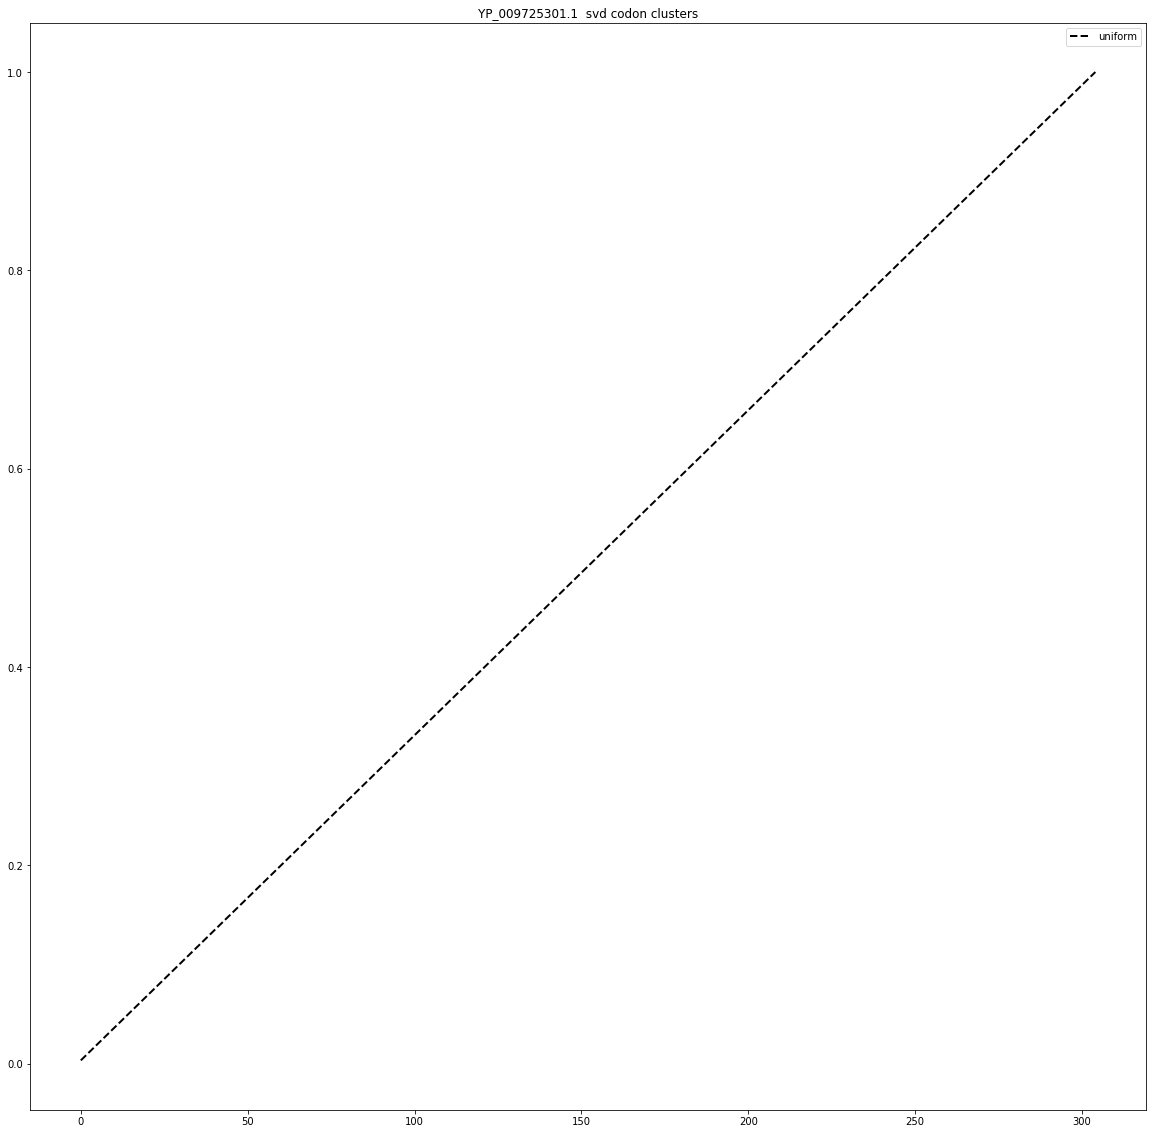

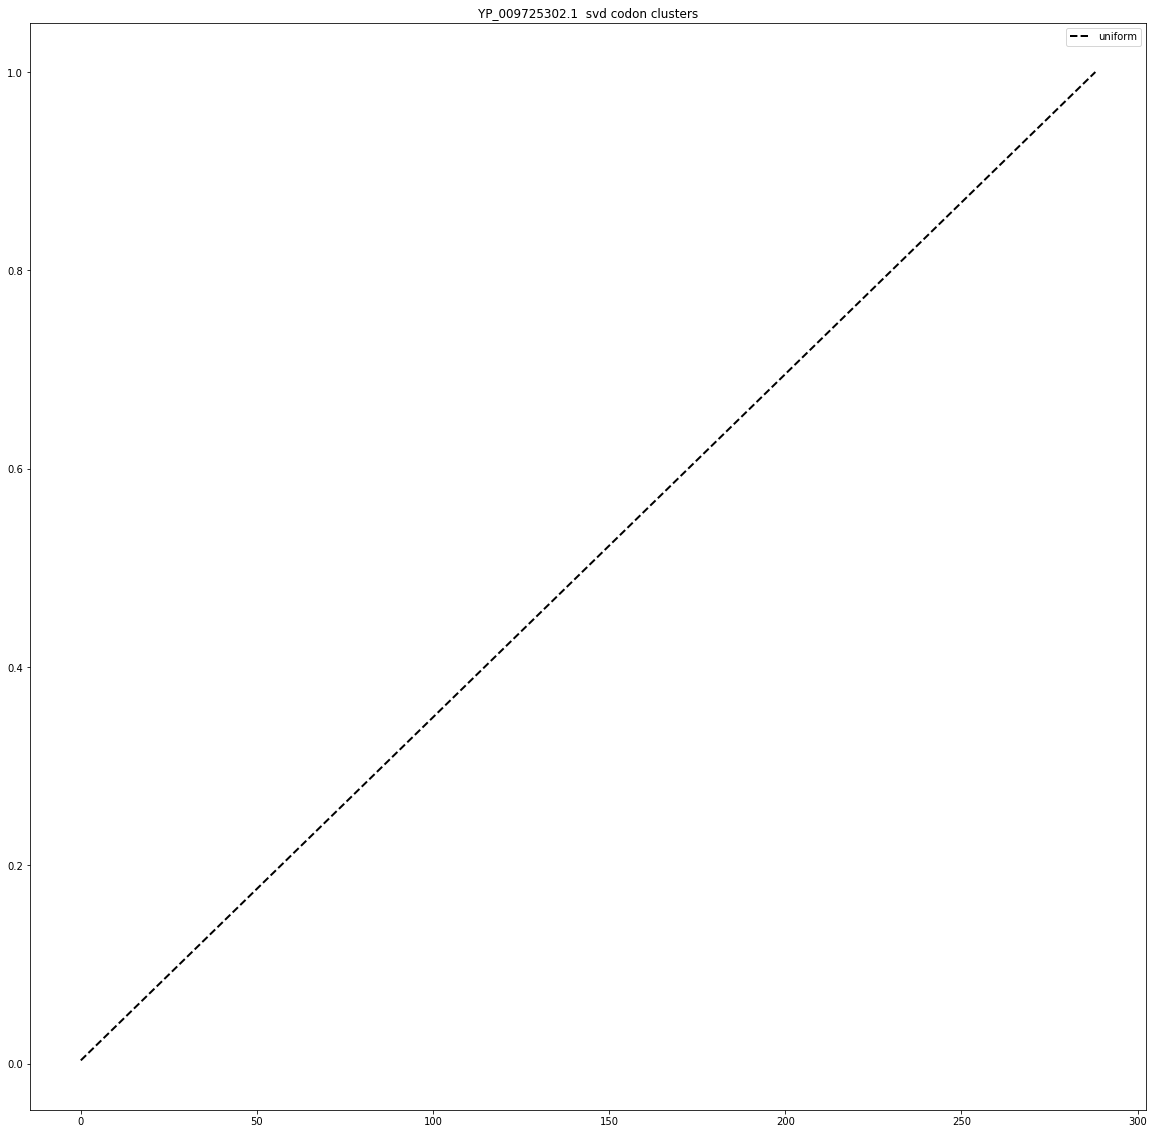

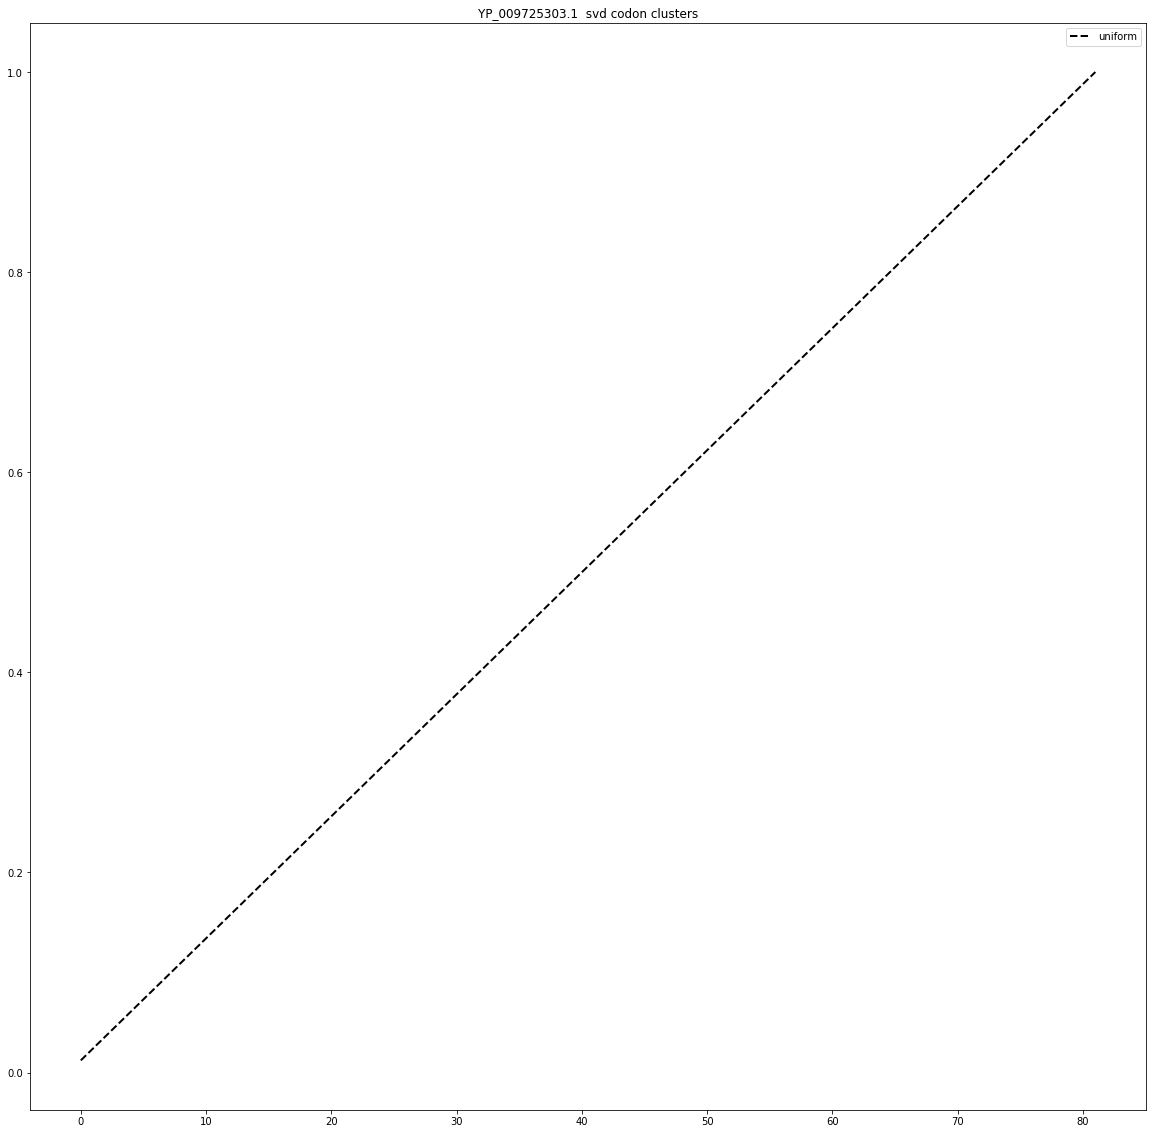

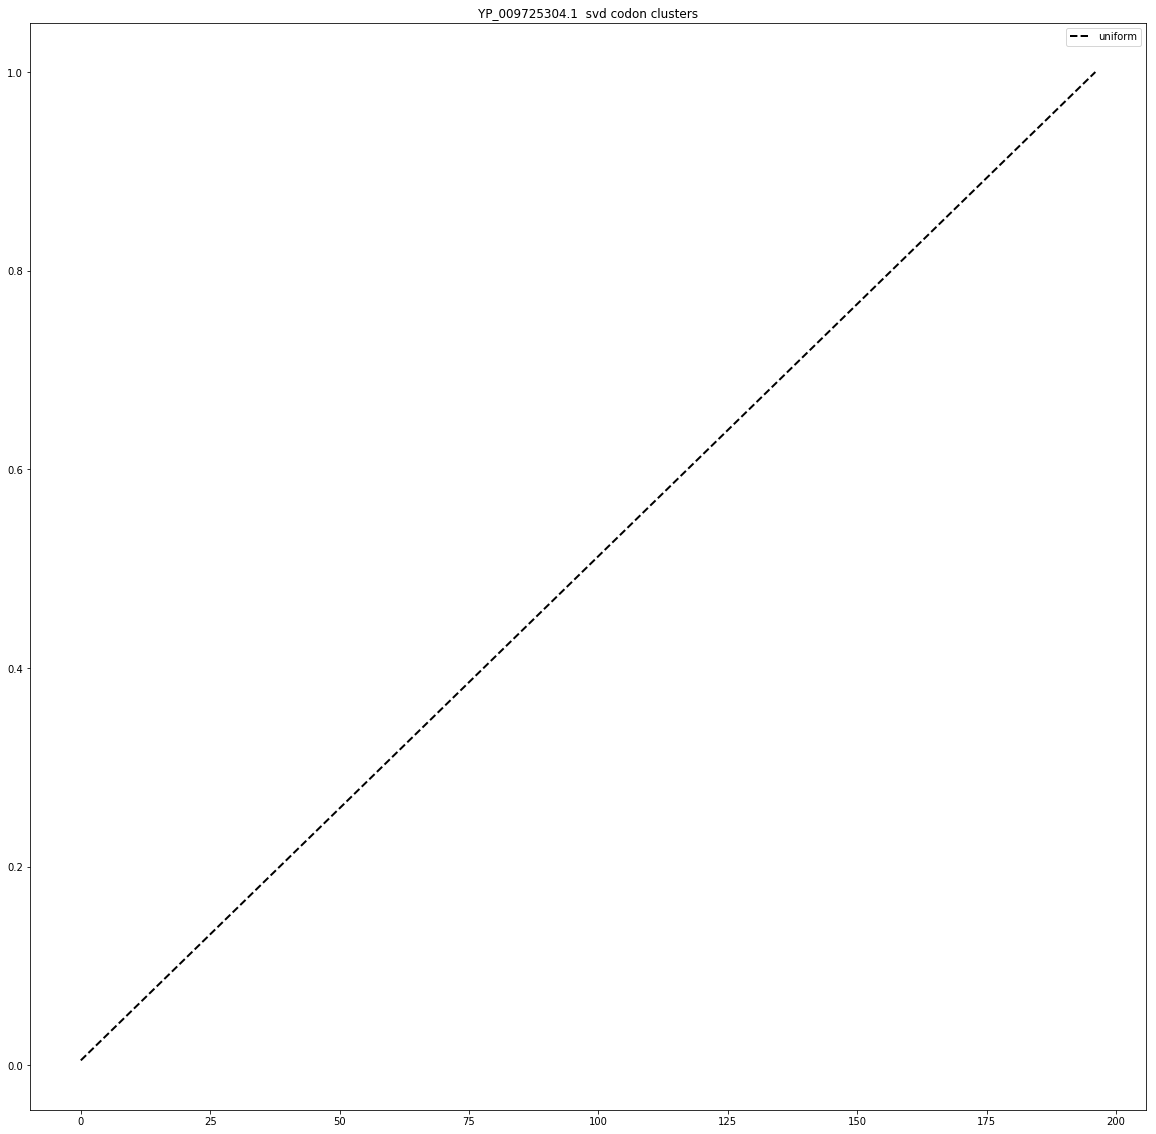

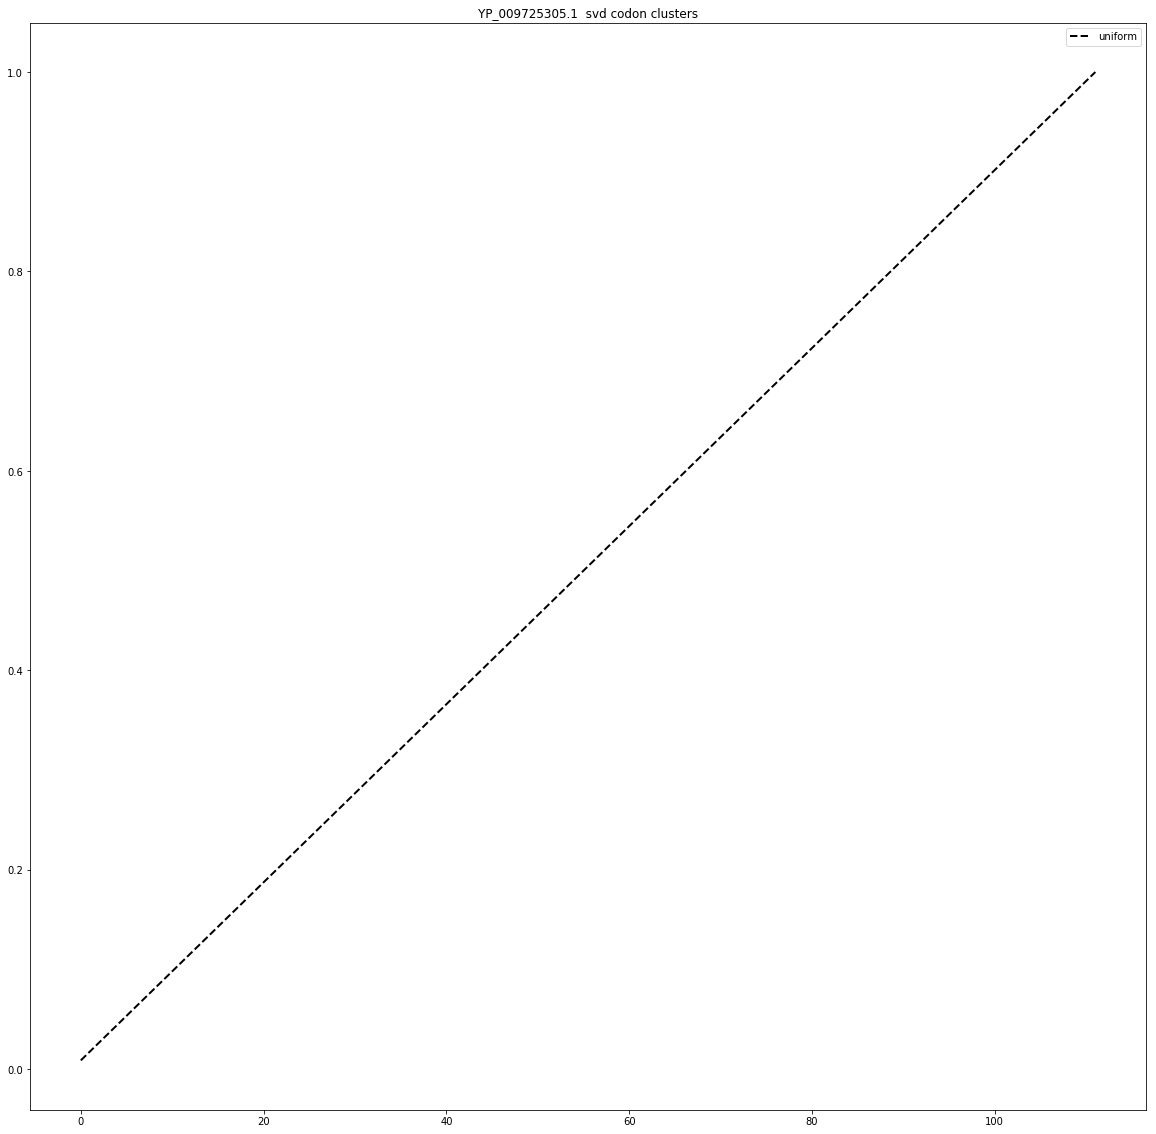

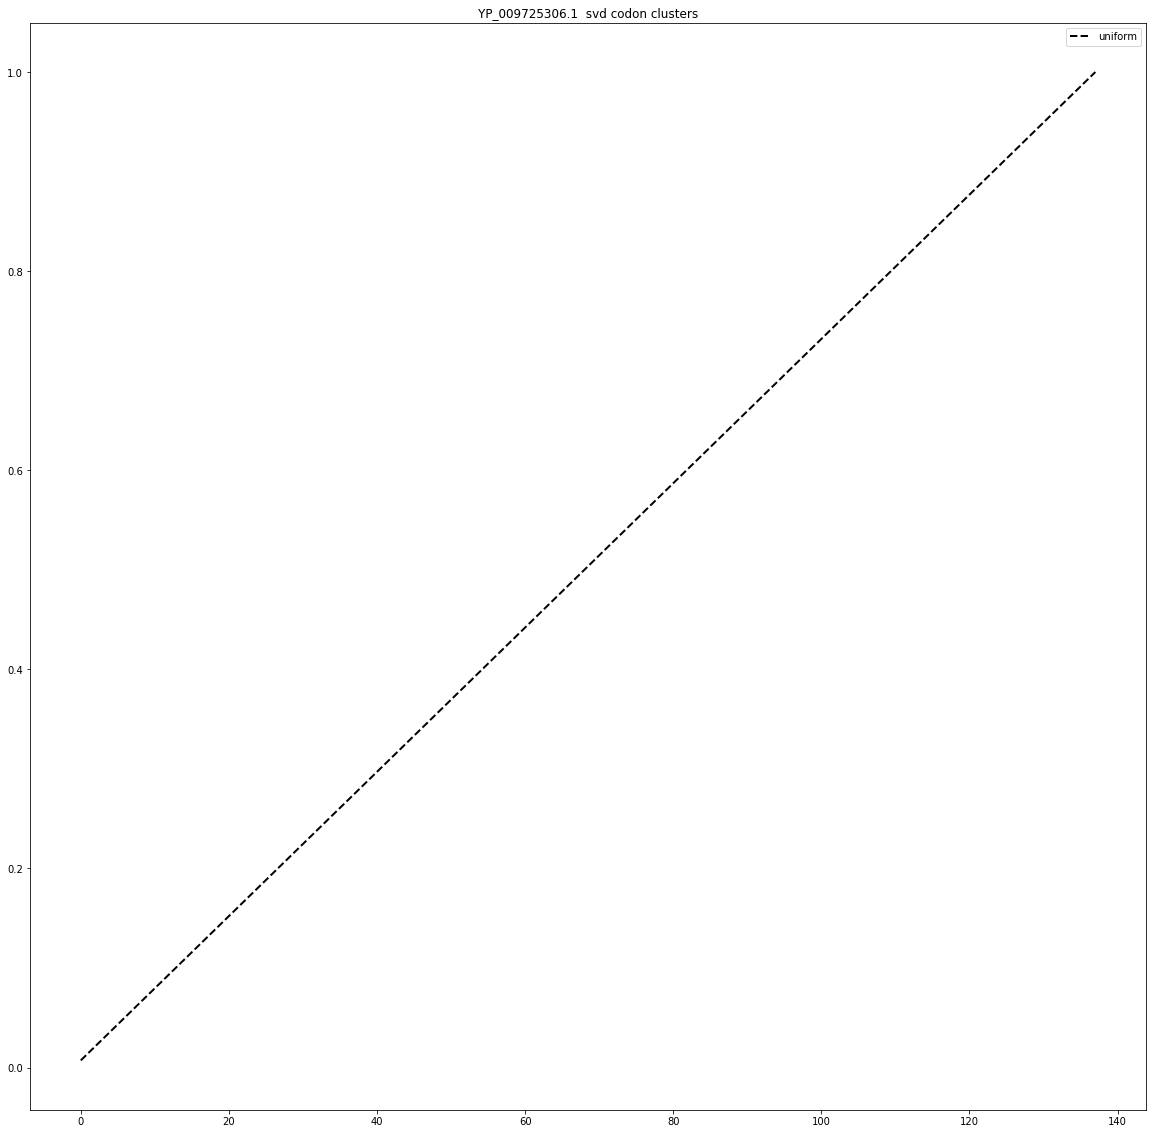

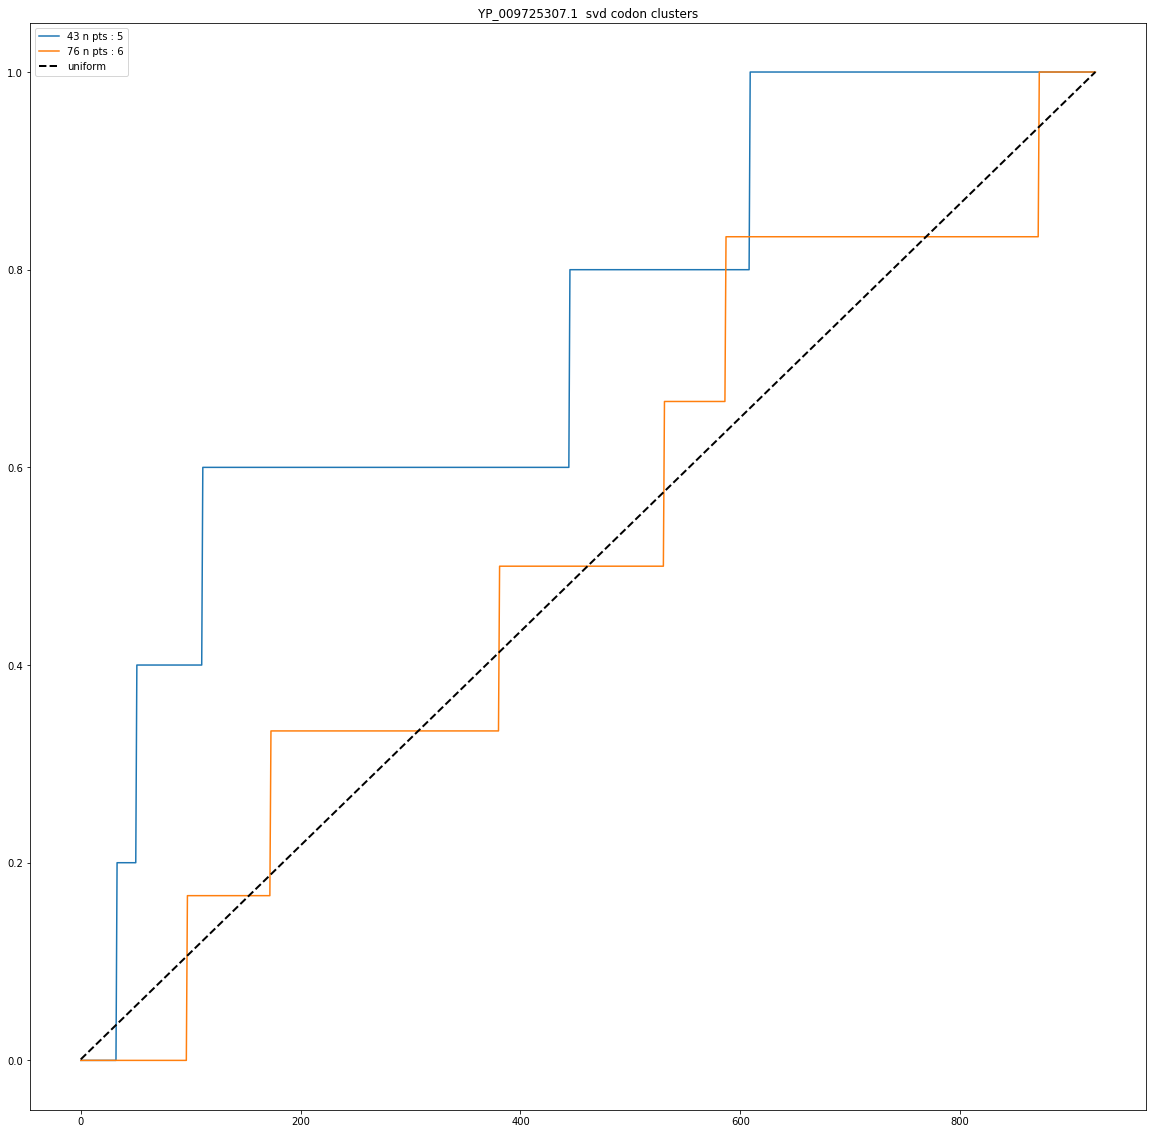

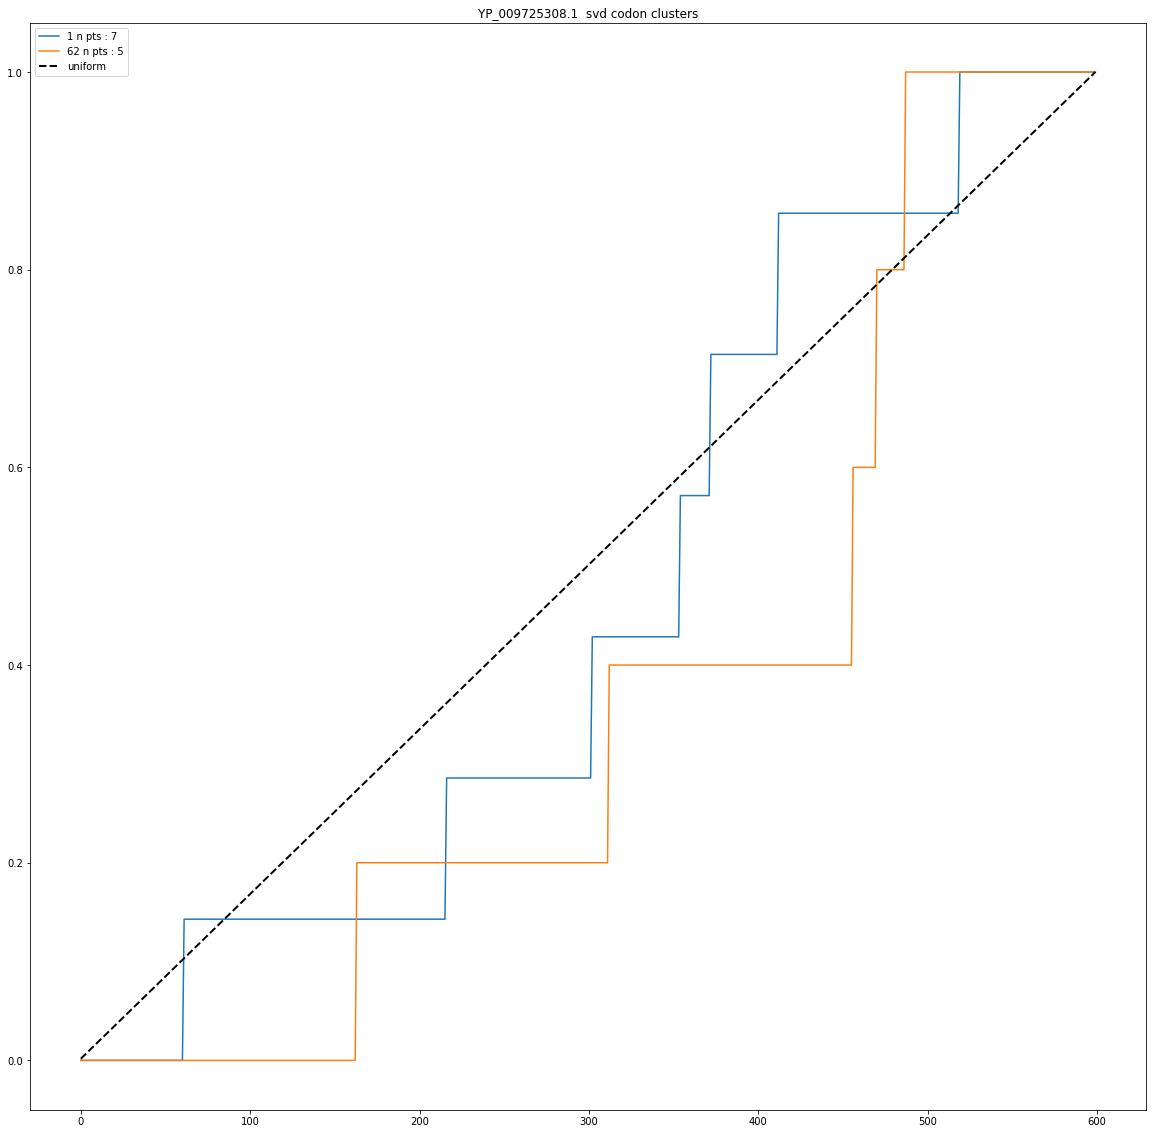

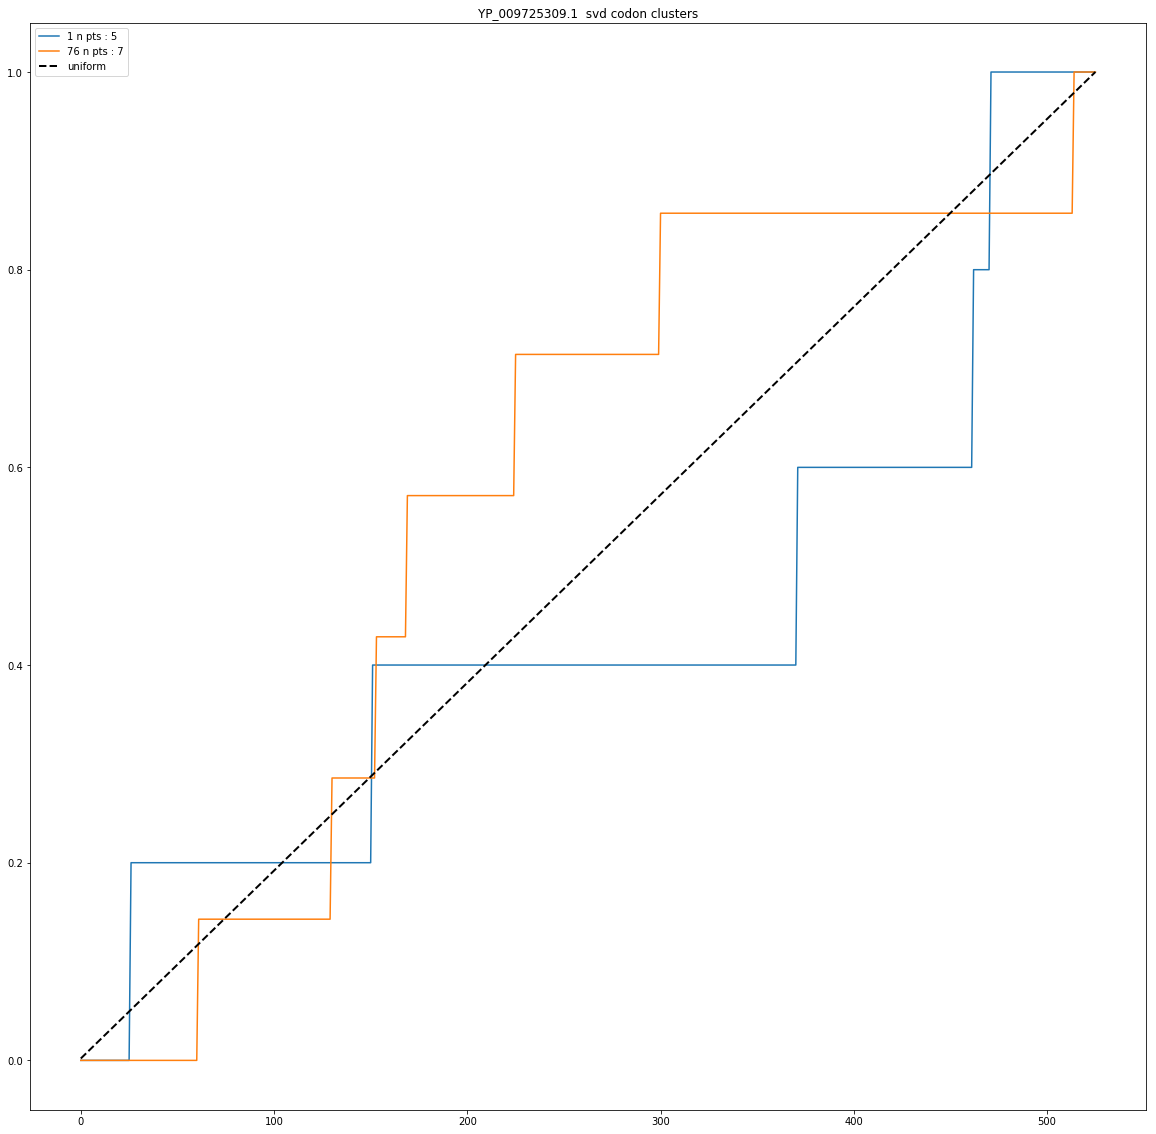

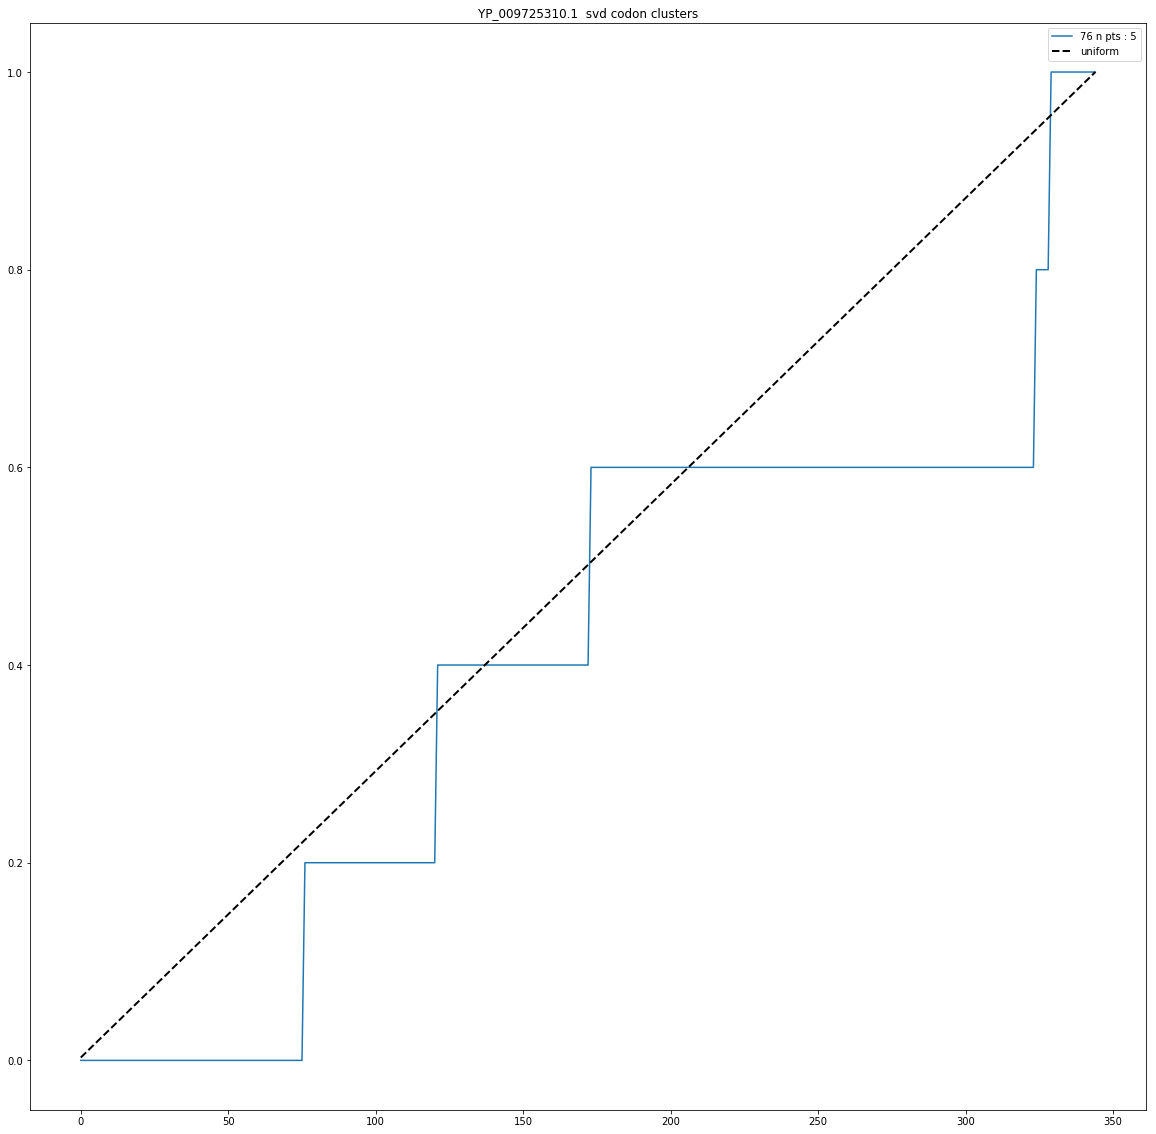

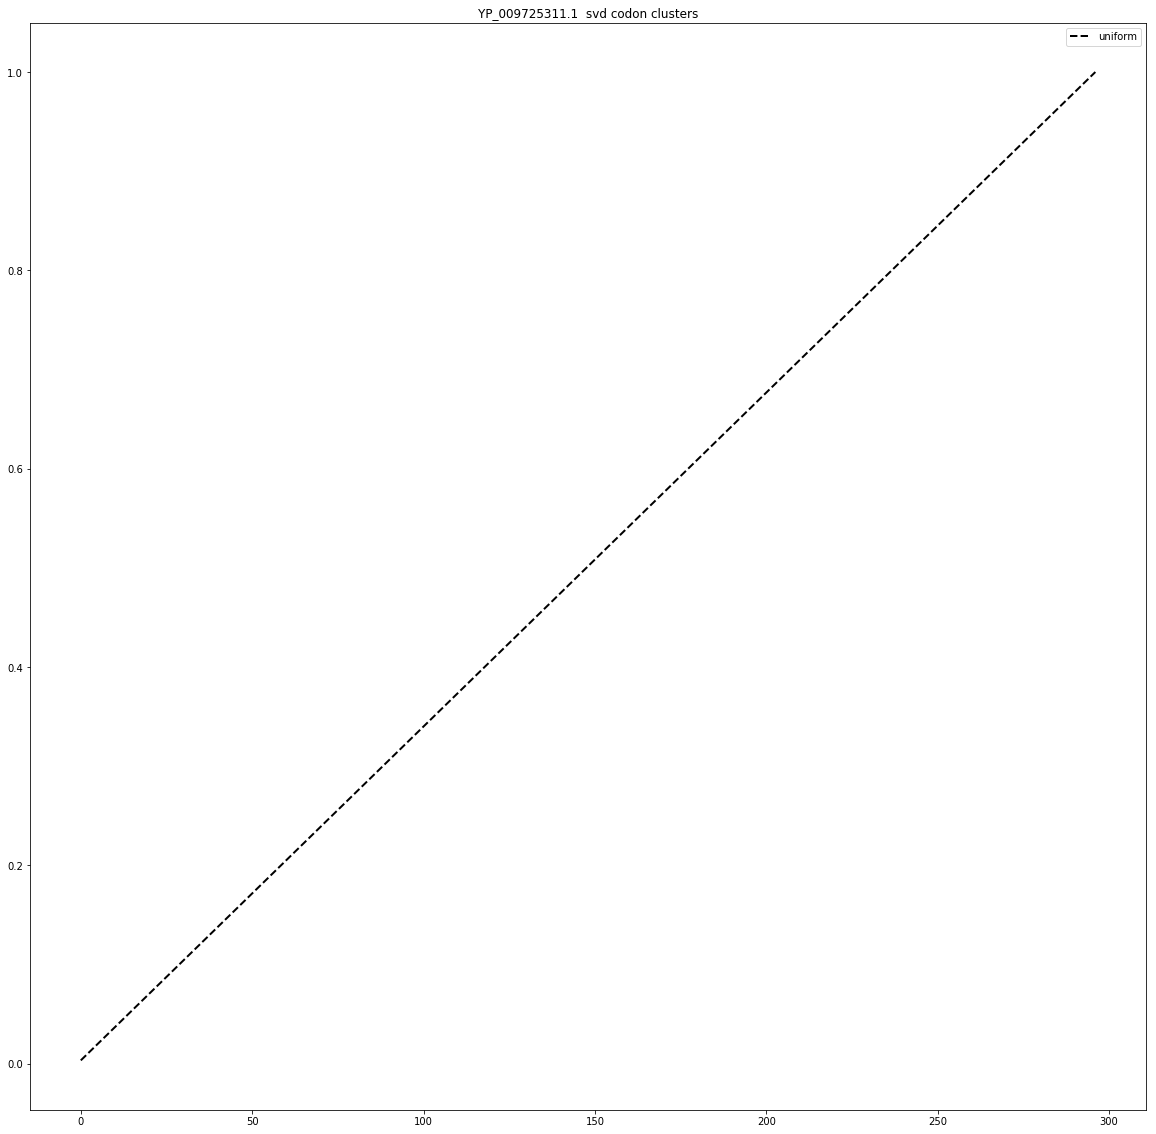

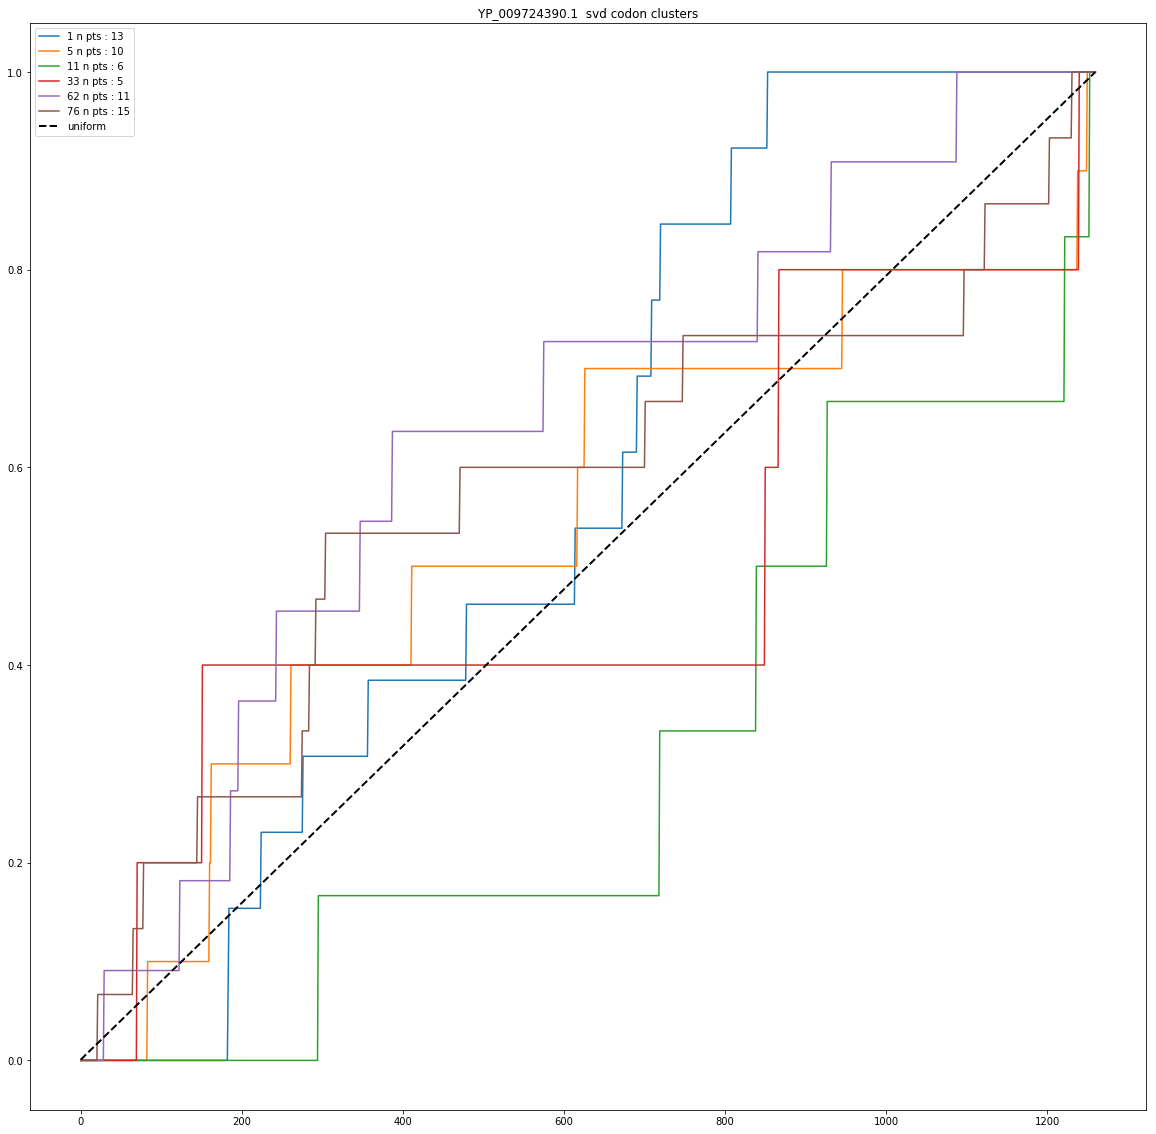

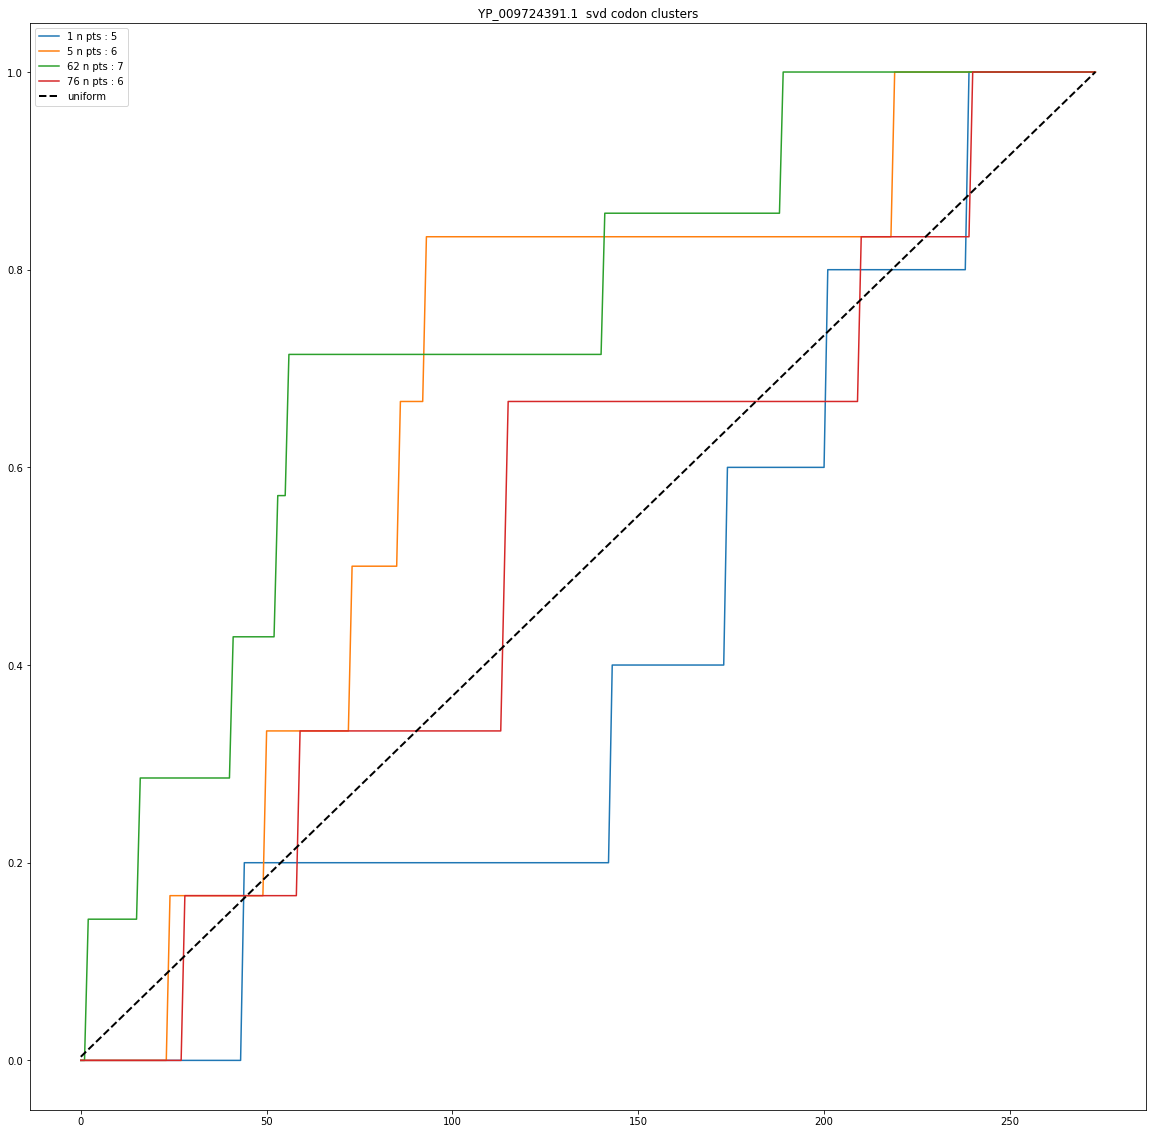

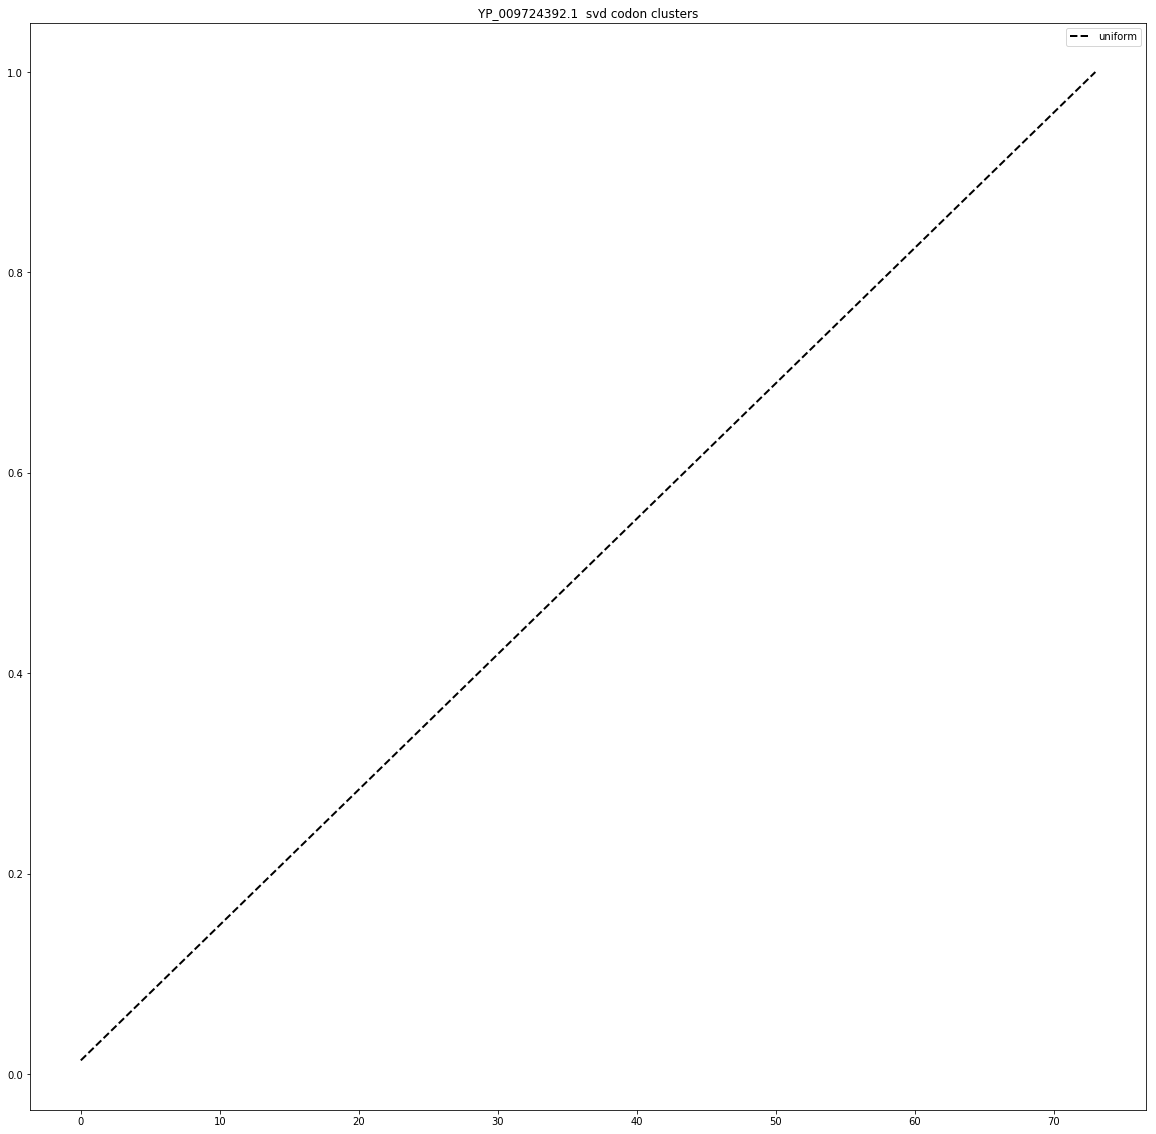

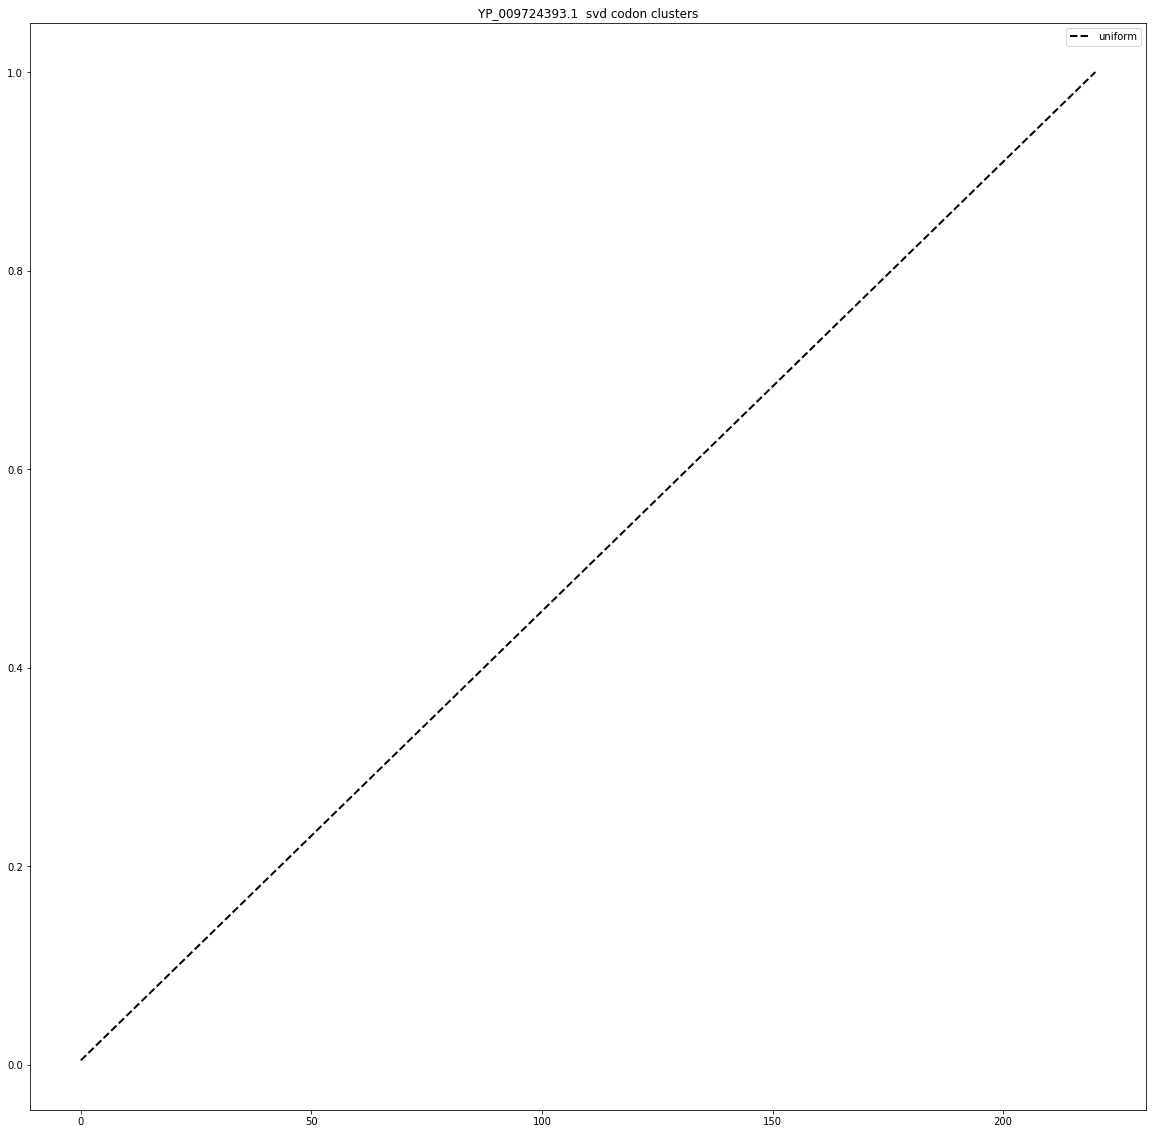

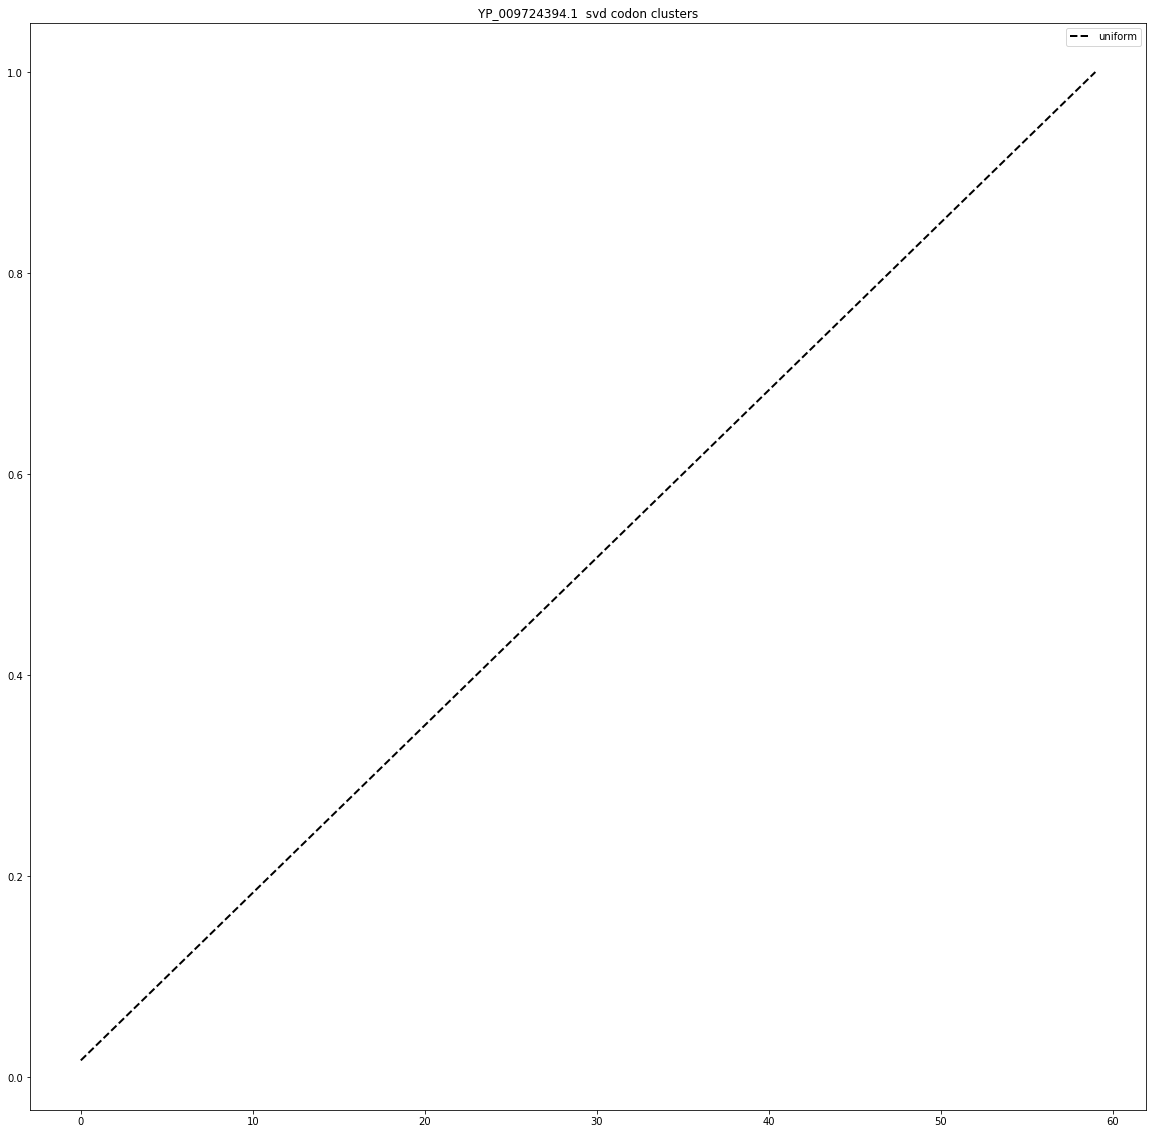

1
(array([ True,  True,  True,  True,  True,  True,  True]), array([3.09966928e-016, 2.71289903e-245, 3.27439581e-032, 1.39397072e-024,
       3.57847973e-043, 3.80653682e-117, 6.44230258e-025]), 0.007300831979014655, 0.0071428571428571435)
5
(array([ True,  True,  True,  True]), array([2.83437749e-043, 1.86875951e-111, 1.08403681e-045, 1.25834070e-061]), 0.012741455098566168, 0.0125)
62
(array([ True,  True,  True,  True,  True]), array([2.27898509e-039, 1.54591944e-172, 1.92213256e-069, 9.67749959e-122,
       6.82393741e-066]), 0.010206218313011495, 0.01)
76
(array([ True,  True,  True,  True,  True,  True,  True]), array([4.38040258e-52, 3.15211717e-63, 2.16178441e-31, 6.00340940e-38,
       4.61776470e-35, 4.60129911e-95, 2.32916236e-14]), 0.007300831979014655, 0.0071428571428571435)
4
(array([ True]), array([9.00672773e-214]), 0.050000000000000044, 0.05)
7
(array([ True]), array([1.27406349e-174]), 0.050000000000000044, 0.05)
11
(array([ True,  True]), array([4.03023066e-156, 1.2

In [195]:
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
#over the whole genome
titles = ' codon clusters, svd codon clusters'.split(',')


for k,dataset in enumerate(titles):
    bonferroni1 = []
    bonferroni2= {}
    for j,row in annotation[annotation[dataset].notna()].iterrows():
        plt.figure( figsize=(20,20))
        
        for cluster in row[dataset]:
            
            
            cluster_ones = np.zeros(len(row.prots))        
            cluster_ones[ row[dataset][cluster] ] = 1  
            if np.sum(cluster_ones) > 4 and np.sum(cluster_ones) < 1000 :    
                cdf_empirical= np.cumsum(cluster_ones) / np.sum(cluster_ones)
                res = stats.kstest(cdf_empirical, 'uniform')
                plt.plot( cdf_empirical  , label = str(cluster) + ' n pts : '+ str(int(np.sum(cluster_ones)) ) )
                bonferroni1.append(res[1])
                if cluster not in bonferroni2:
                    bonferroni2[cluster]=[]
                bonferroni2[cluster].append(res[1])
        cdf_uniform = np.cumsum(np.ones(len(row.prots)) ) / np.sum(len(row.prots))
        plt.plot(cdf_uniform, lw = 2 , ls = 'dashed' , c = 'black' , label= 'uniform')
        plt.legend()
        plt.title( row.sseqid + ' ' + titles[k] )
        plt.show()
        
    for c in bonferroni2:
        print(c)
        bf_correction = multipletests(bonferroni2[c], alpha=0.05 , method='bonferroni', is_sorted=False, returnsorted=False)
        print(bf_correction)
    
    bf_correction = multipletests(bonferroni, alpha=0.05 , method='bonferroni', is_sorted=False, returnsorted=False)
    print(bf_correction)
    